In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import eigh
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks
from scipy.integrate import simps

from collections import Counter
from itertools import product
from collections import namedtuple

from multiprocessing import Pool
from tqdm.notebook import tqdm

import cvxpy as cp

# Loading and pre-processing pulses

Load pulses. Note that each pulse has its own time axis

In [2]:
%ls "experimental data 01-21-2022"

export_F05_SO_test_x.txt  export_F07_SO_test_x.txt  export_SO_test_long_x.txt
export_F06_SO_test_x.txt  export_F08_SO_test_x.txt


In [3]:
pulses = {}

# declare type
Pulse = namedtuple('Pulse', ['time', 'field', 'interp_field', 'peaks_time', 'half_period'])

# save index where the field reseaches its maximum
peak_position = {}

for freq in range(5, 9):
    data = np.loadtxt(
        'experimental data 01-21-2022/export_F0{}_SO_test_x.txt'.format(freq)
    )
    time, field = data.T
    
    # check that time is time
    assert np.all(np.diff(time) > 0), "`time` is probably not time"
    
    label = '0.{} THz'.format(freq)
    
    # Relabel time axis such that peak field is at zero time 
    abs_field = np.abs(field)
    indx = abs_field.argmax()
    peak_position[label] = indx
    #time -= time[indx] 
    
    
    # Extract information for the combinatorial method 
    #peaks_time = time[find_peaks(abs_field, height=0.6 * abs_field.max())[0]]
    
    #if freq == 8:
    #    peark_index = find_peaks(abs_field)[0][1:]
    #else:
    #    peark_index = find_peaks(abs_field)[0]
    peark_index = find_peaks(abs_field)[0][1:-1]
    
    peaks_time = time[peark_index]
    half_period = Counter(np.diff(peaks_time)).most_common(1)[0][0]
    
    # Add neighboring points to allow fine tunning  
    new_peark_index = np.hstack([peark_index -2, peark_index -1, peark_index, peark_index + 1, peark_index + 2])
    
    # Saving the data 
    pulses[label] = Pulse(
        time, 
        field, 
        UnivariateSpline(time, field, ext='zeros', s=0),
        time[new_peark_index],#peaks_time,
        half_period,
    )
    
    

# saving the largest frequency
largest_freq = label

In [4]:
peak_position

{'0.5 THz': 15, '0.6 THz': 173, '0.7 THz': 108, '0.8 THz': 23}

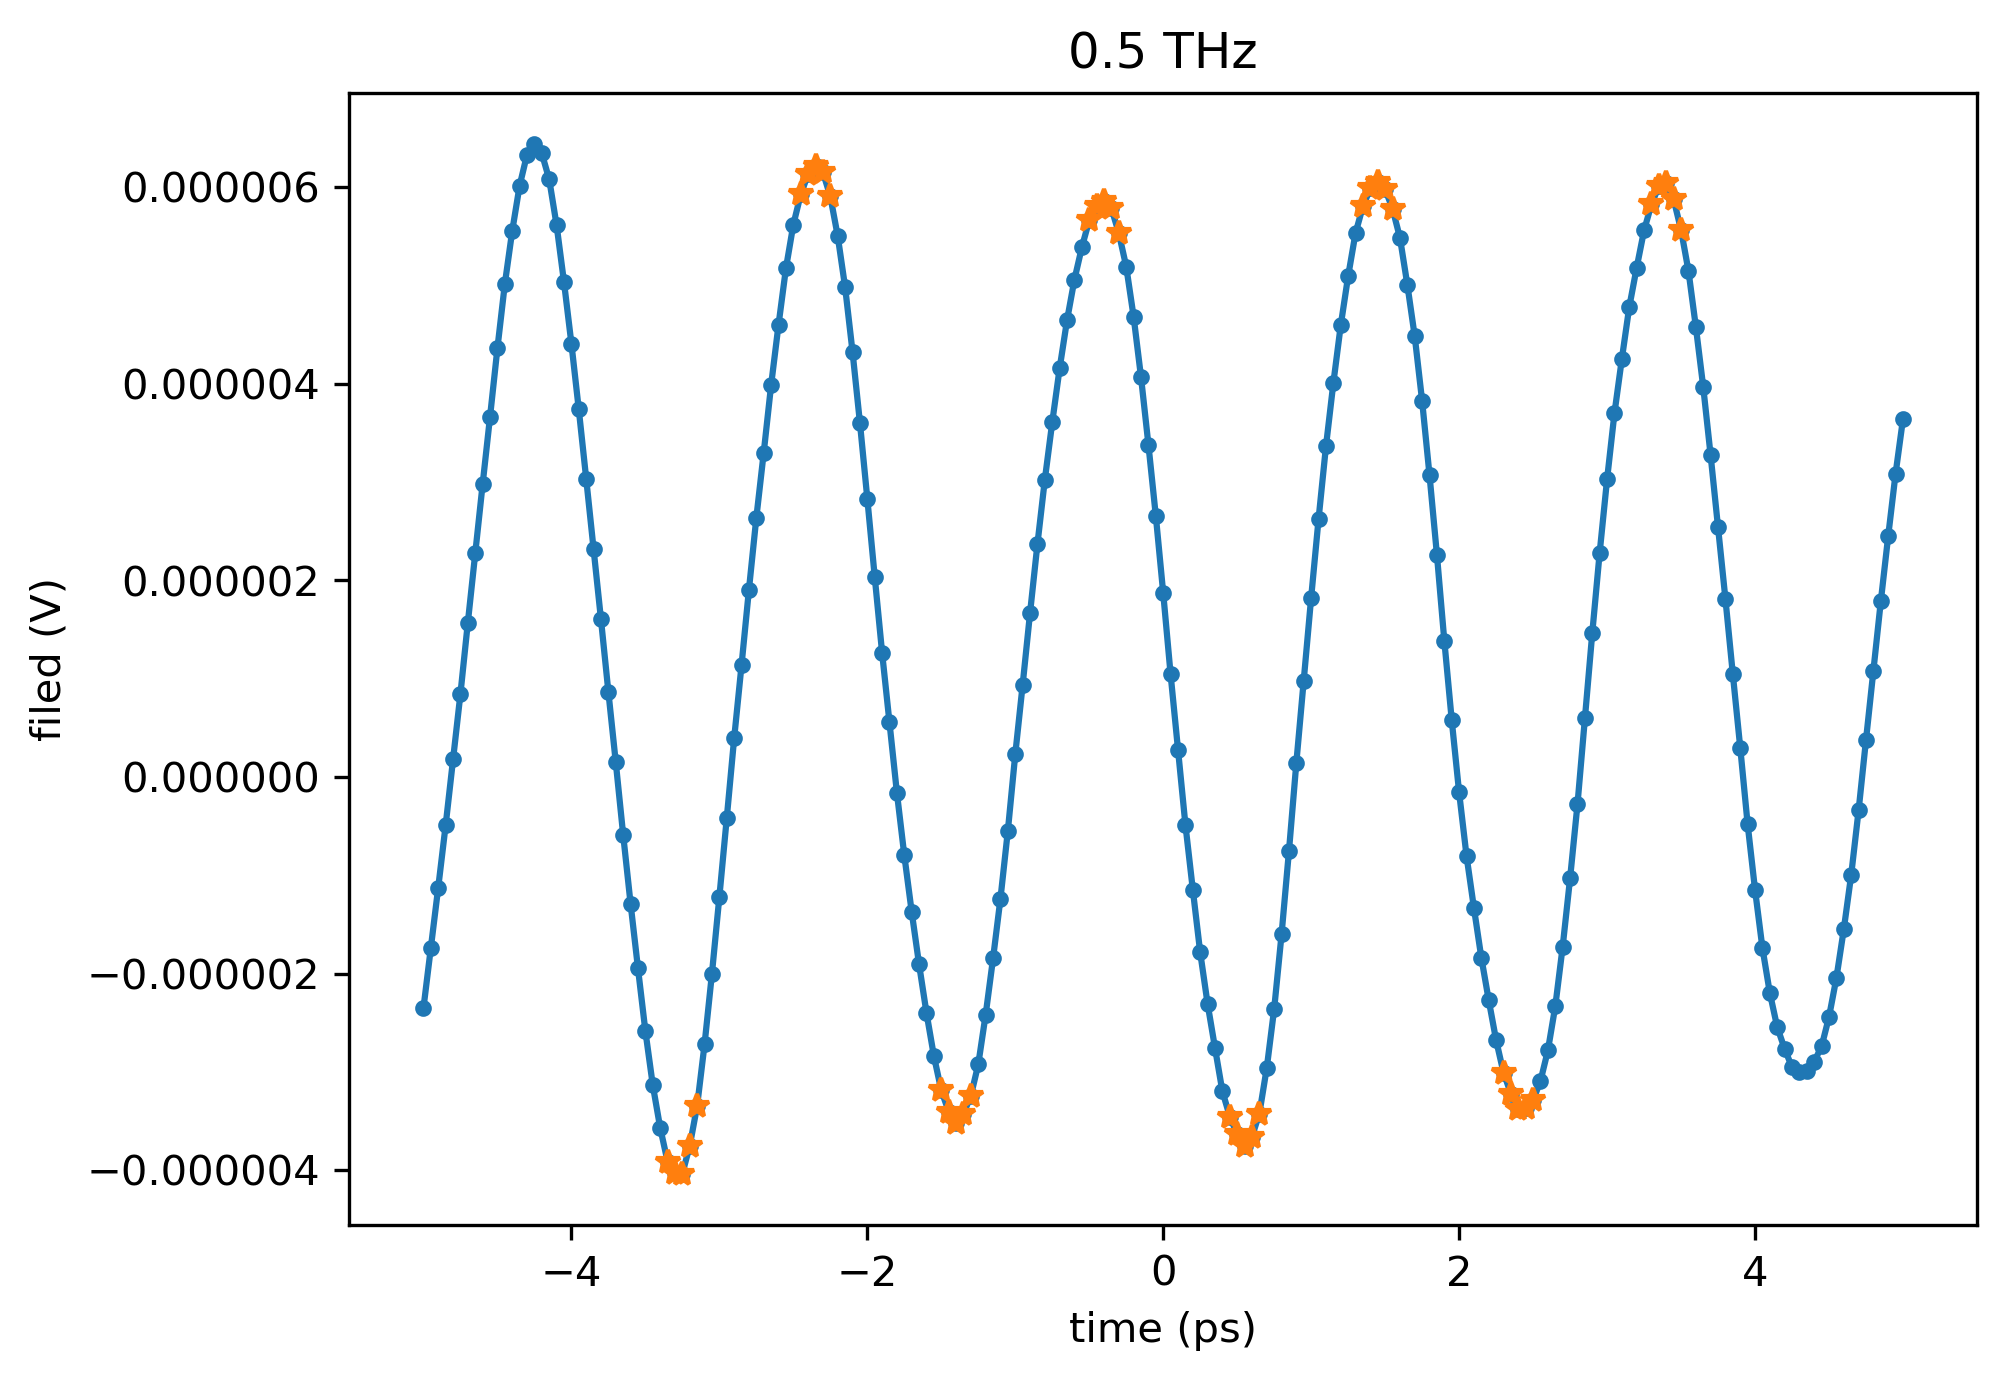

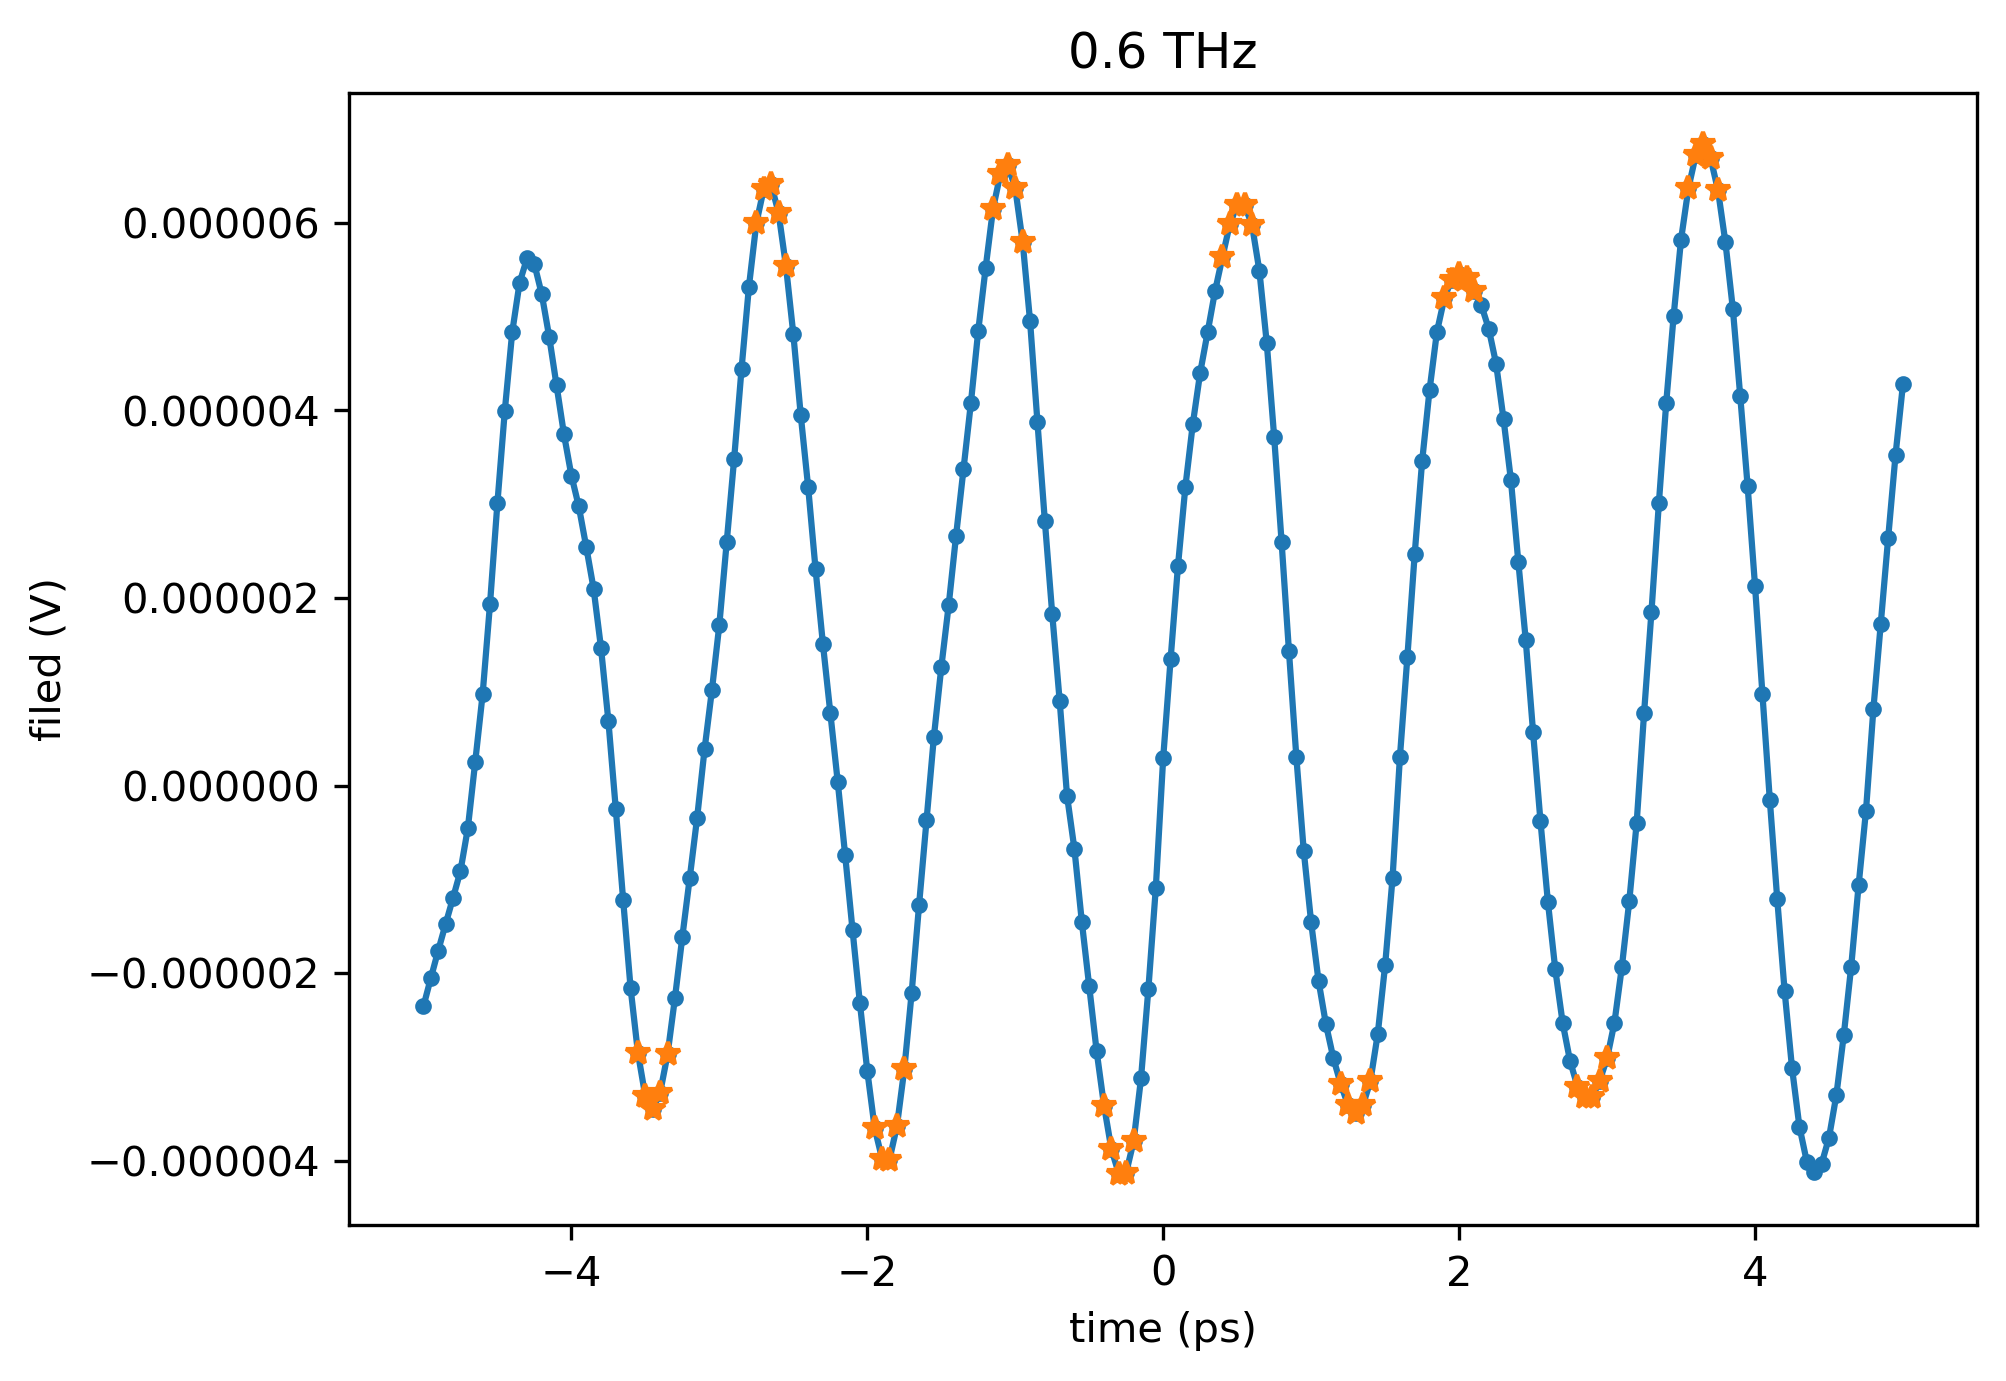

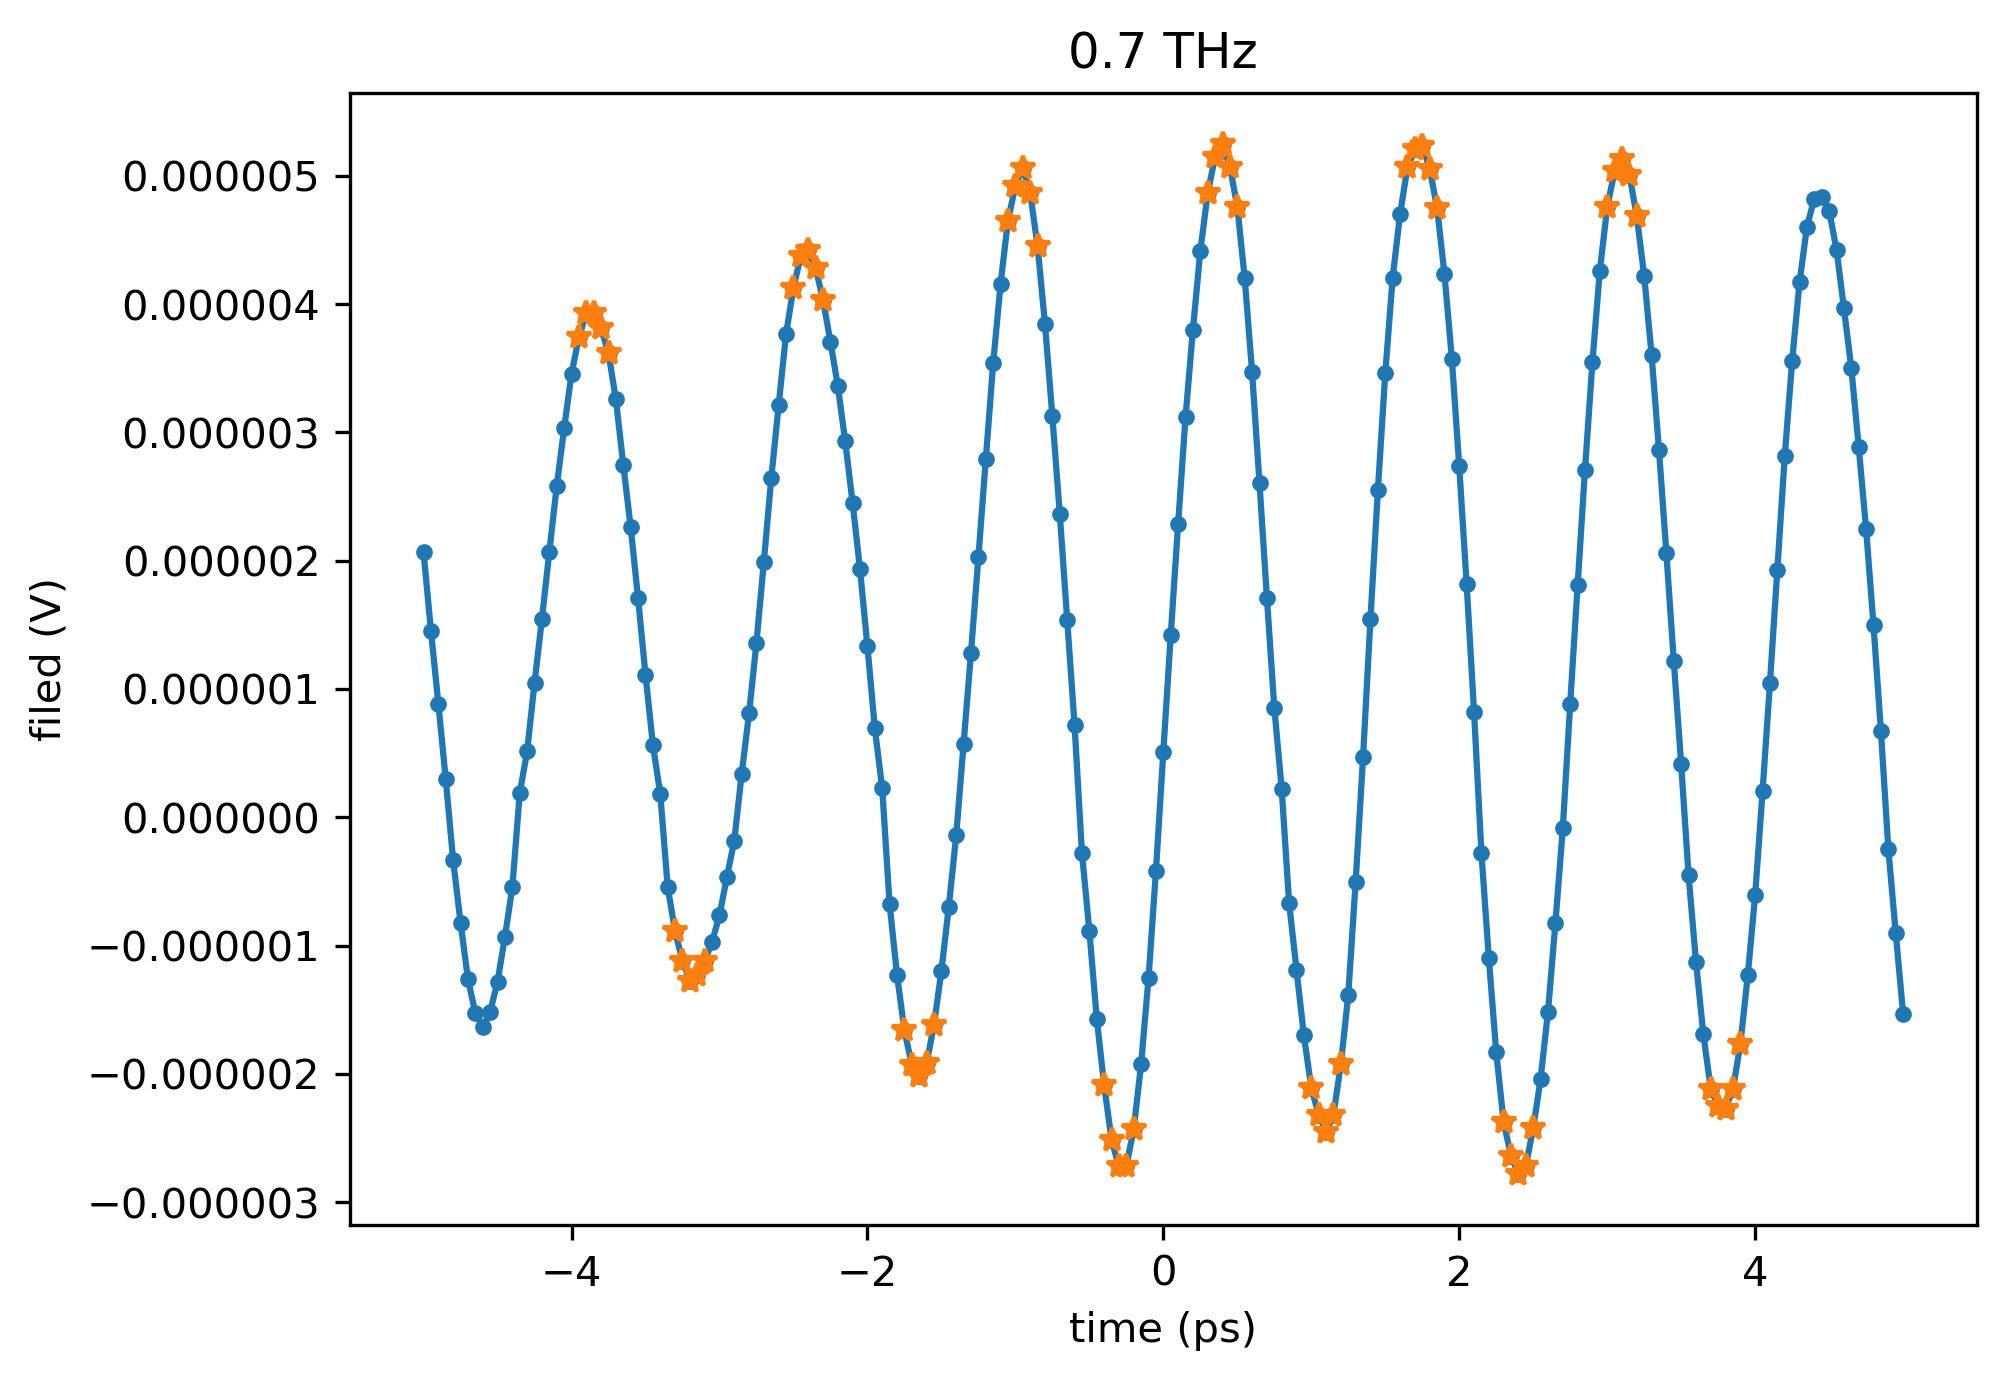

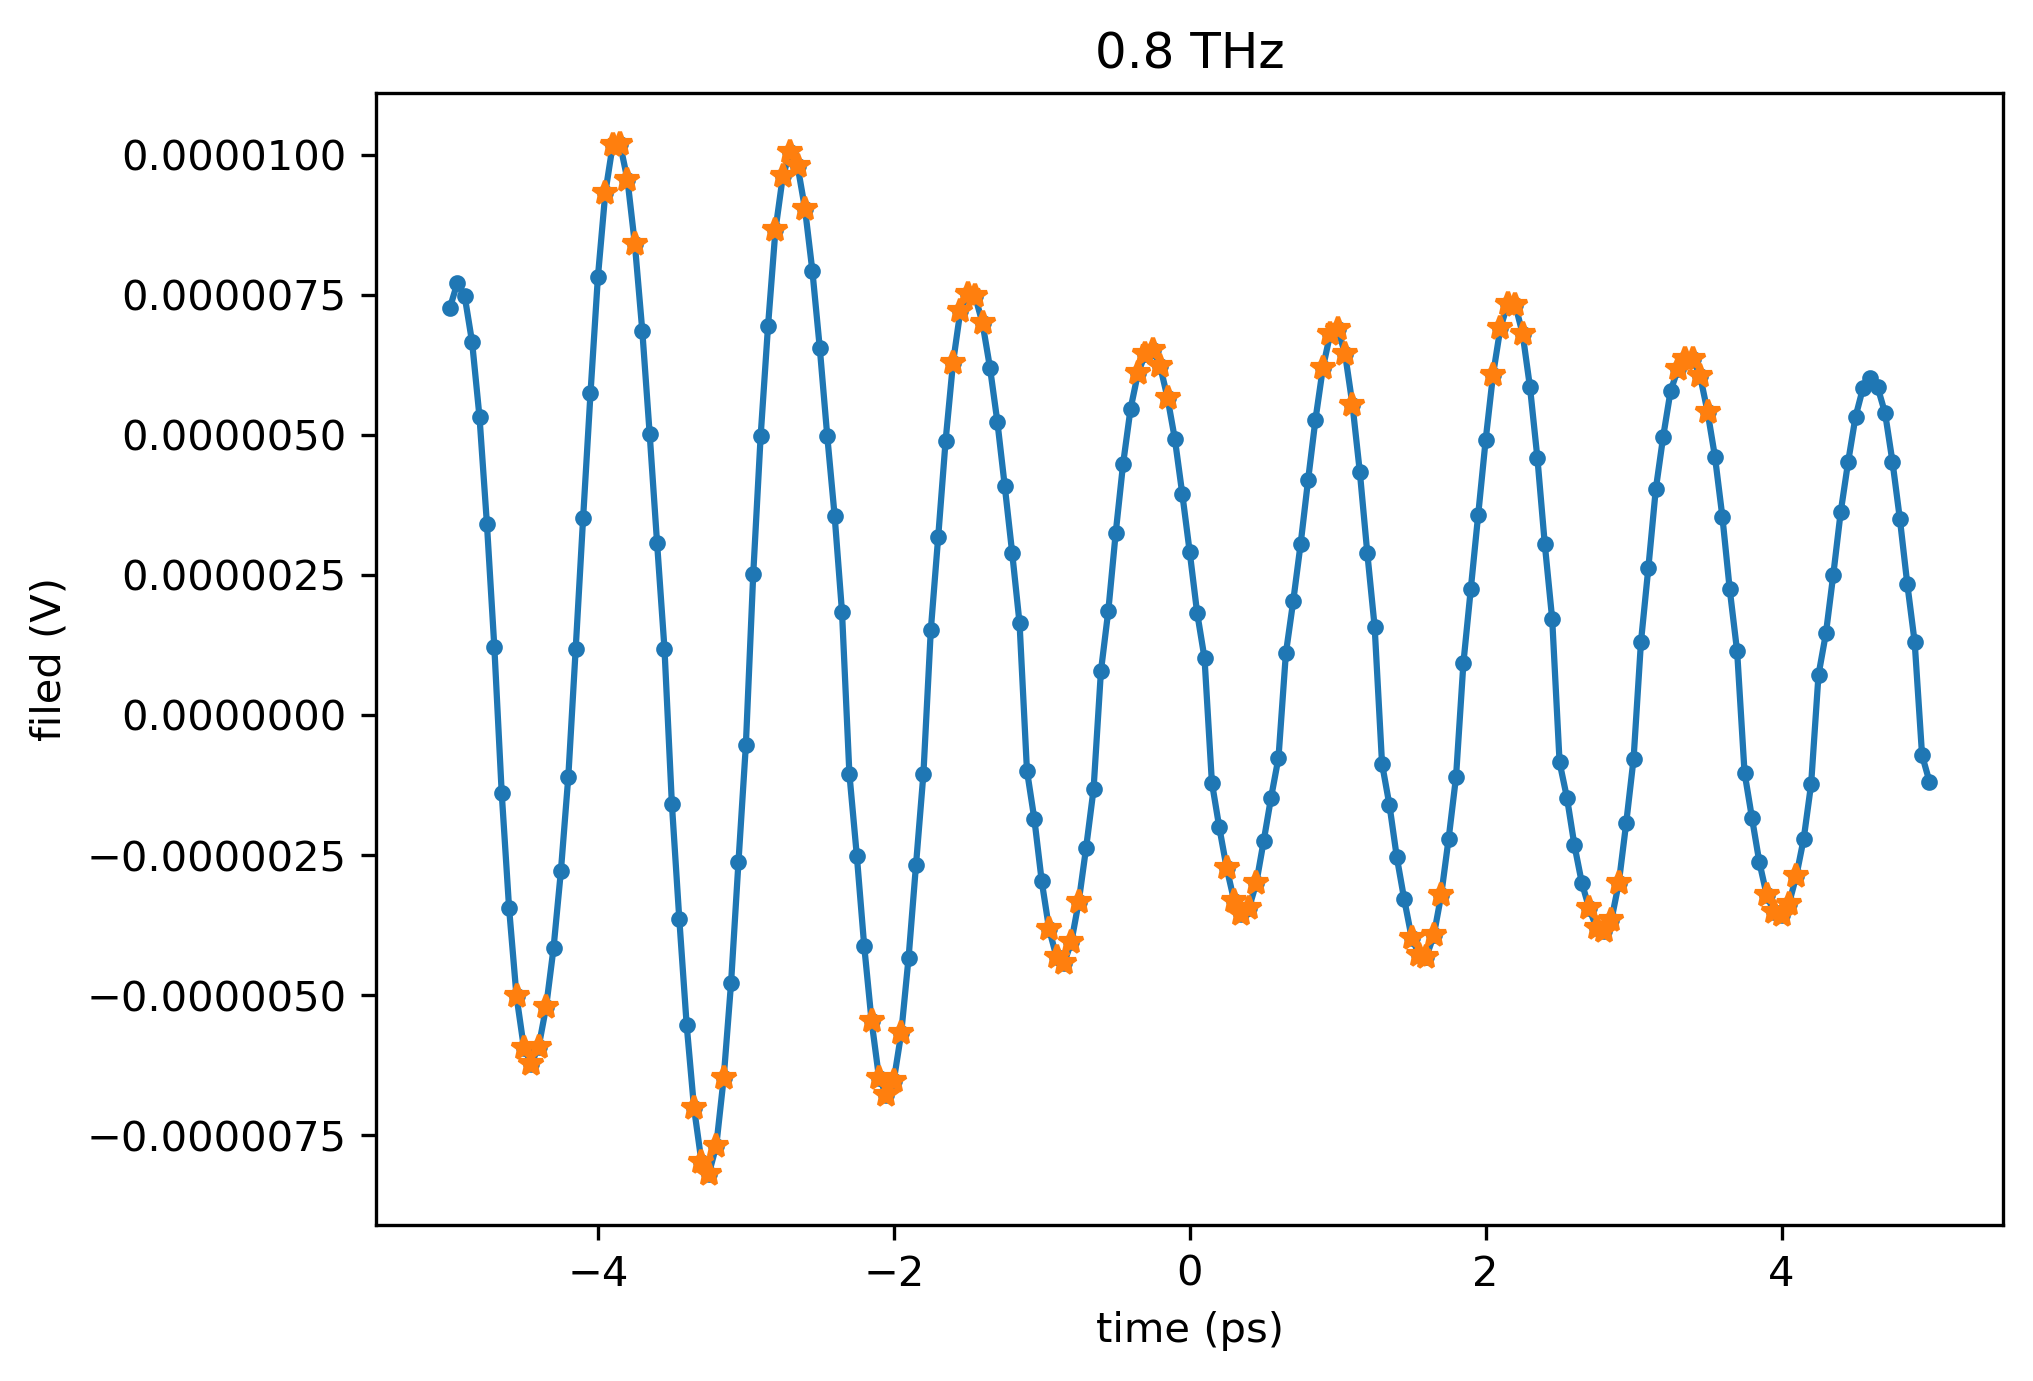

In [5]:
# Plot pulses
for freq, data in pulses.items():
    
    plt.figure(figsize=(7, 5), dpi=300)
    plt.title(freq)
    
    plt.plot(data.time, data.field, '.-')
    plt.plot(data.peaks_time, data.field[np.searchsorted(data.time, data.peaks_time)], '*')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (V)')
    plt.show()  
    

### Load combined pulse

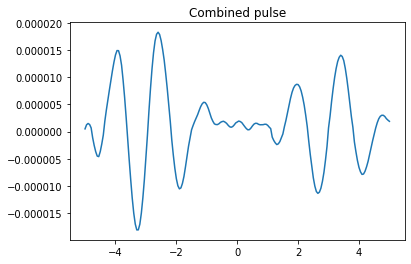

In [6]:
data = np.loadtxt('experimental data 01-21-2022/export_SO_test_long_x.txt')
time, field = data.T
    
# check that time is time
assert np.all(np.diff(time) > 0), "`time` is probably not time"

combined_pulse = Pulse(
    time, 
    field, 
    UnivariateSpline(time, field, ext='zeros', s=0),
    None,
    None
)
    
plt.title("Combined pulse")
plt.plot(combined_pulse.time, combined_pulse.field)
plt.show()

### Manually extract observational time window 

0.6000000000000001


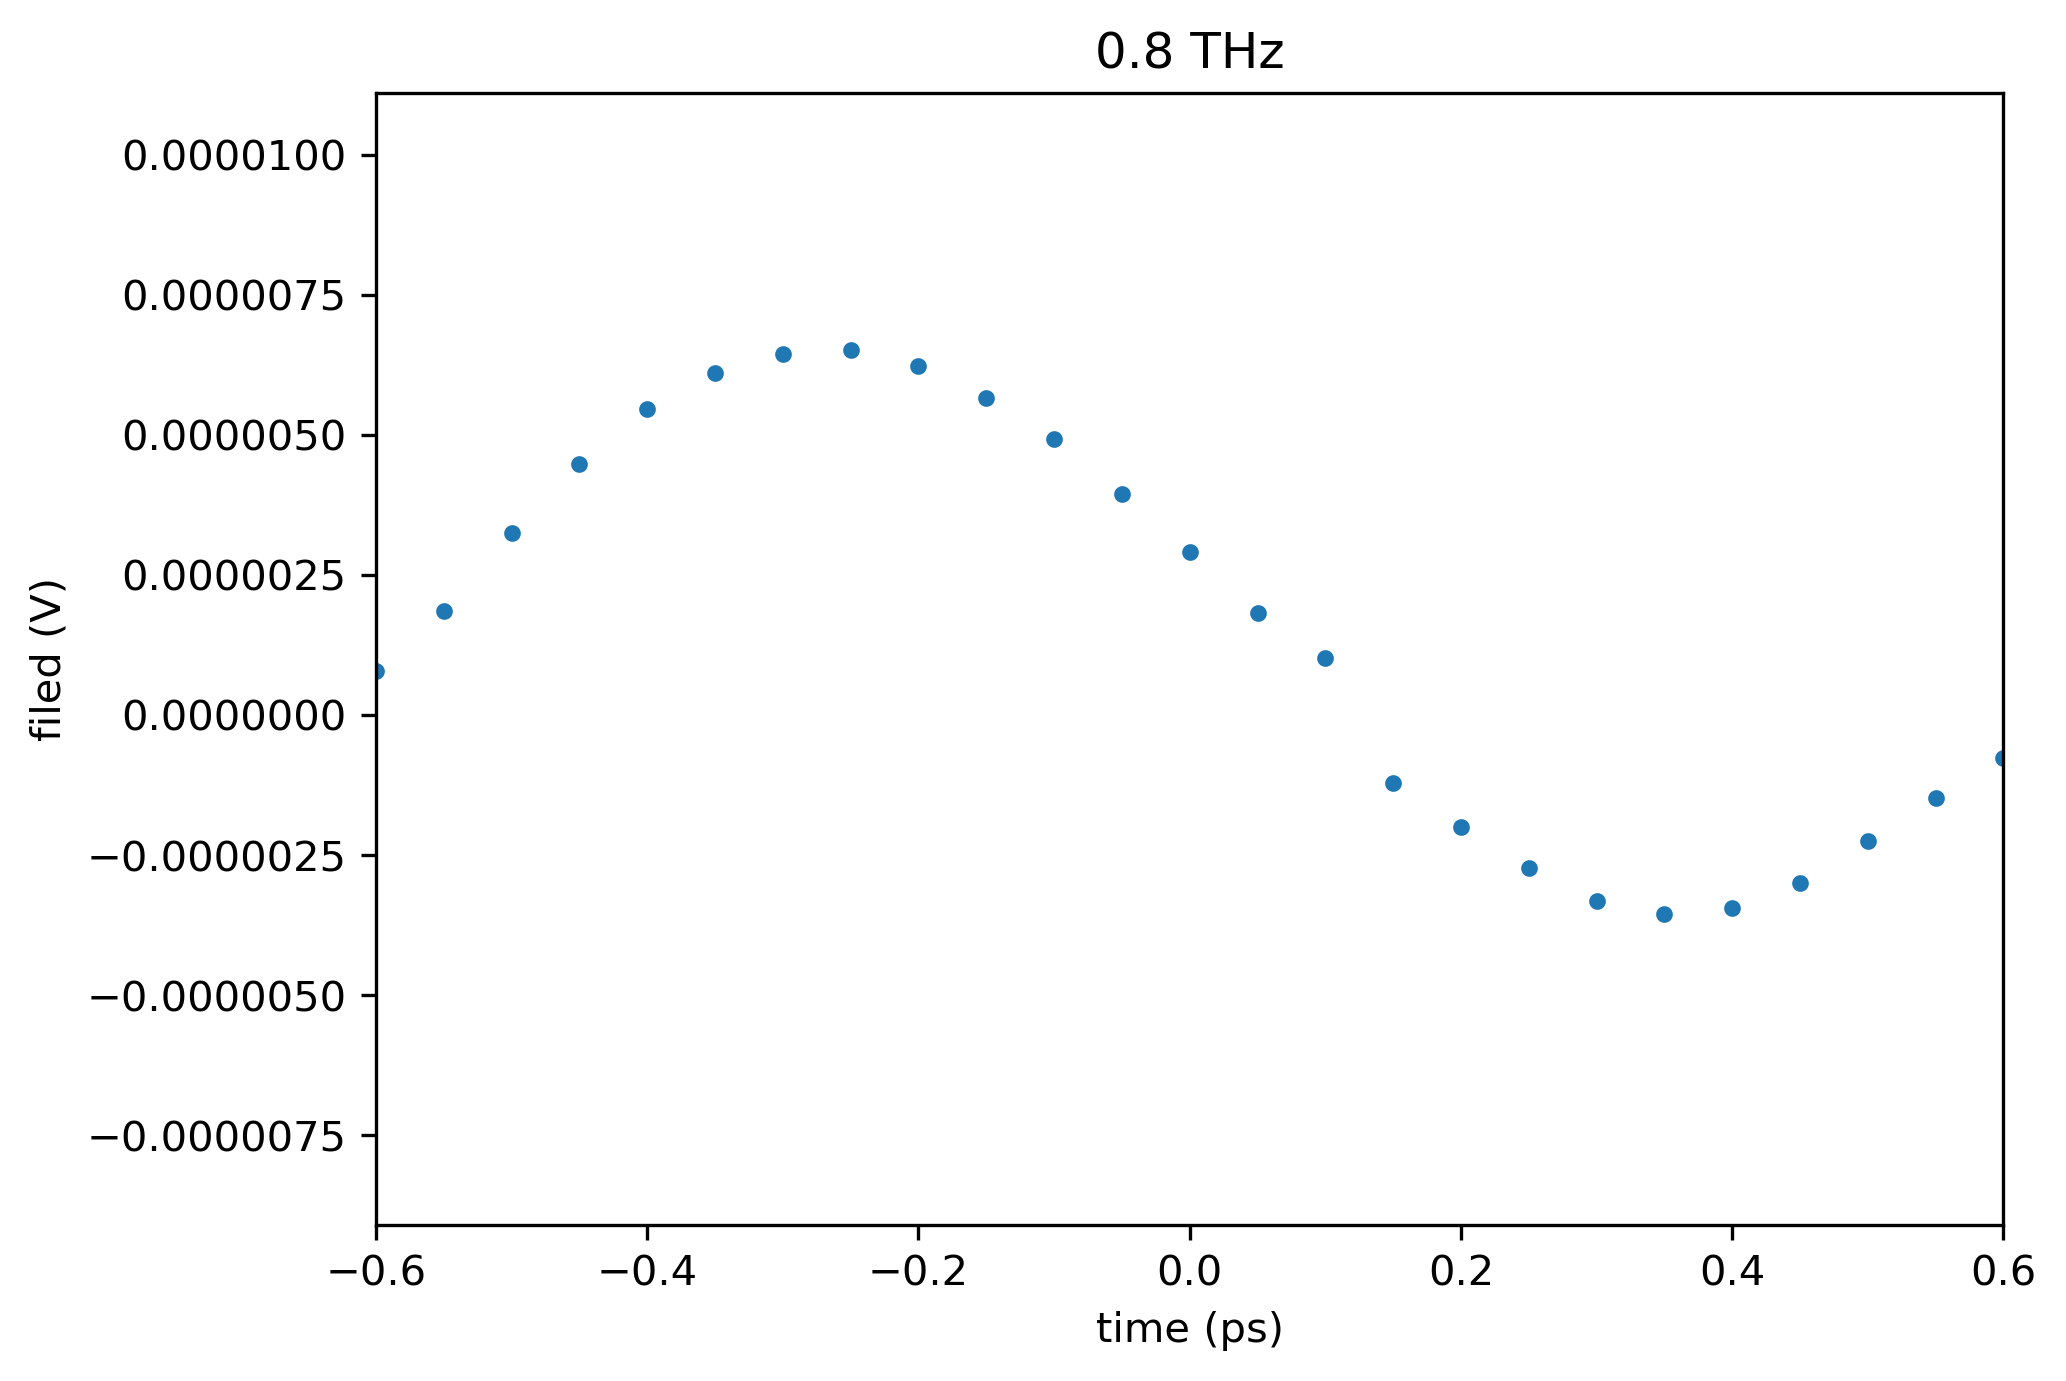

In [7]:
plt.figure(figsize=(7, 5), dpi=300)
    
time = pulses[largest_freq].time
field = pulses[largest_freq].field
half_period = pulses[largest_freq].half_period

print(half_period)

plt.plot(time, field, '.')

#indx = peak_position[largest_freq]
indx = 200

observational_window = -half_period, half_period
#observational_window = time[indx - 14], time[indx + 12]

plt.xlim(observational_window)
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.title(largest_freq)    
plt.show()

### Plot all pulses within the observational window

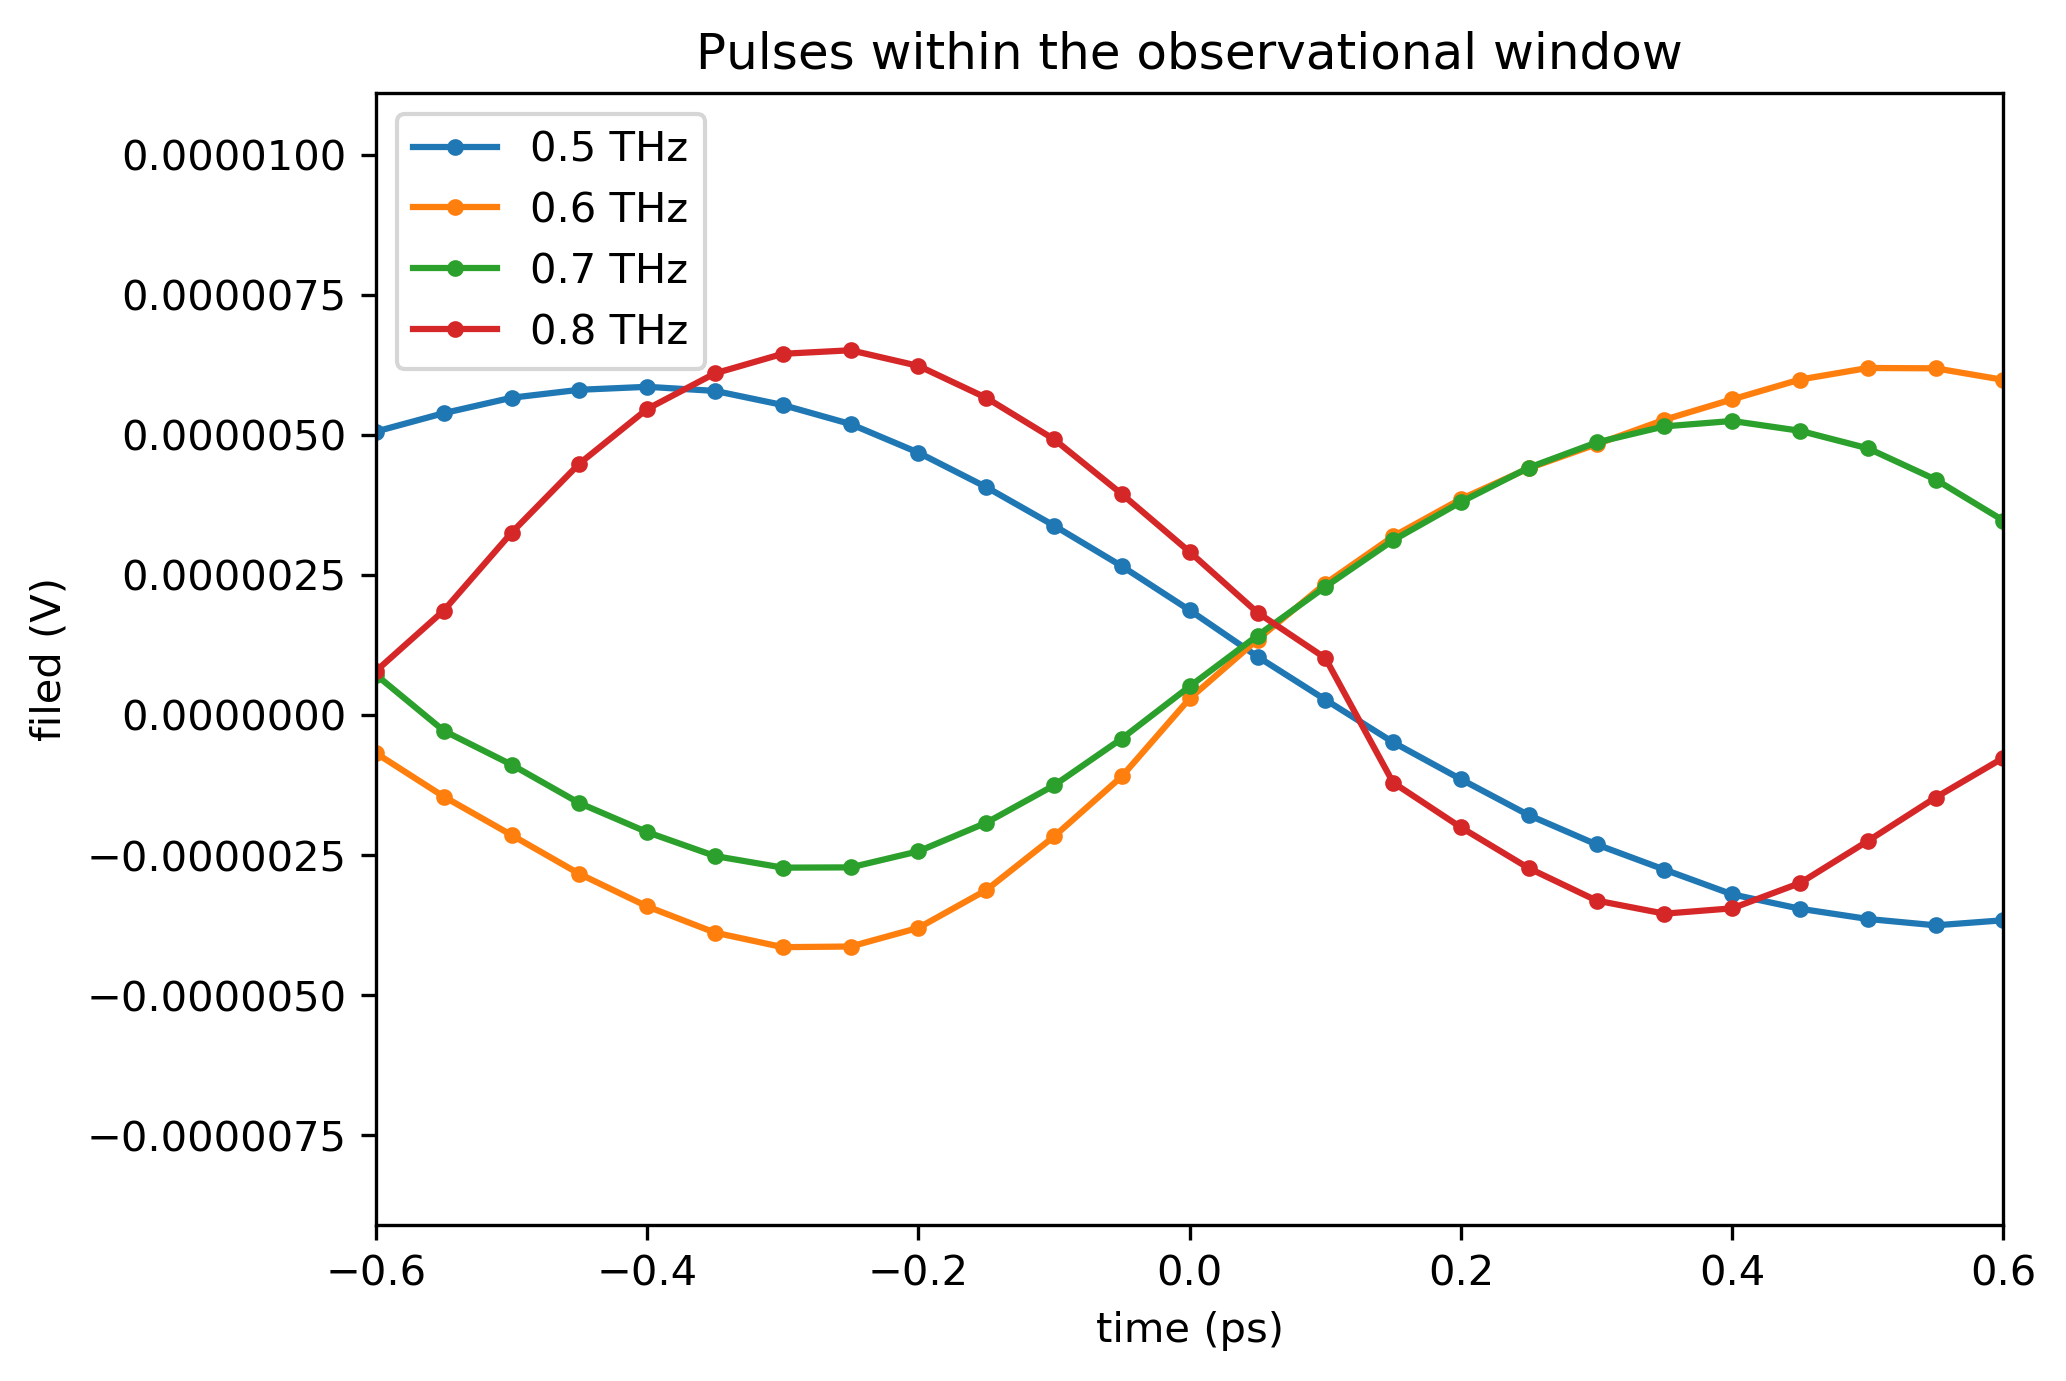

In [8]:
# Plot pulses
plt.figure(figsize=(7, 5), dpi=300)

plt.title("Pulses within the observational window")

for freq, data in pulses.items():
    plt.plot(data.time, data.field, '.-', label=freq)
    

#plt.plot(combined_pulse.time, combined_pulse.field, '.-', color='black', label='experimental pulse')
    
plt.xlim(np.array(observational_window))
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')    

plt.legend()
plt.show()  

# Synthesizing superoscillations 

The first step, Calculate the overlap matrix
$$
 S_{ij}(t_1, t_2) = \int_{t_1}^{t_2} E_i(t) E_j(t) dt
$$

In [9]:
def get_overlap(pulse1, pulse2, int_bounds):
    
    # common time axis
    t = np.union1d(pulse1.time, pulse2.time)
    
    return UnivariateSpline(
        t, 
        pulse1.interp_field(t) * pulse2.interp_field(t), 
        ext='zeros', 
        s=0
    ).integral(*int_bounds)

Get $S_{ij}(-\infty, \infty)$

In [10]:
S_infty = [
    [
        get_overlap(pulse1, pulse2, (-np.inf, np.inf)) 
        for pulse2 in pulses.values()
    ] for pulse1 in pulses.values()
]

S_infty = np.array(S_infty)

assert np.allclose(S_infty, S_infty.T)

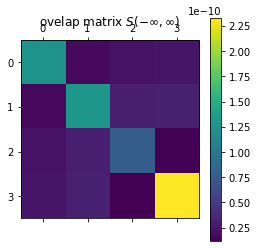

In [11]:
plt.matshow(np.abs(S_infty))
plt.colorbar()
plt.title("ovelap matrix $S(-\infty, \infty)$")
plt.show()

Get overlap matrix for the observational window

In [12]:
S_observ = [
    [
        get_overlap(pulse1, pulse2, observational_window) 
        for pulse2 in pulses.values()
    ] for pulse1 in pulses.values()
]

S_observ = np.array(S_observ)

assert np.allclose(S_observ, S_observ.T)

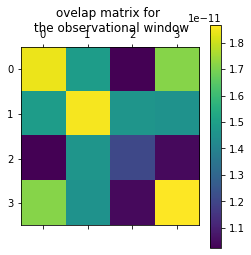

In [13]:
plt.matshow(np.abs(S_observ))
plt.colorbar()
plt.title("ovelap matrix for \n the observational window")
plt.show()

### Finding optimal strategies for generating supperoscilations via eigenvectors

In [14]:
vals, vecs = eigh(S_observ) #, S_infty)

# Ploting superoscilations

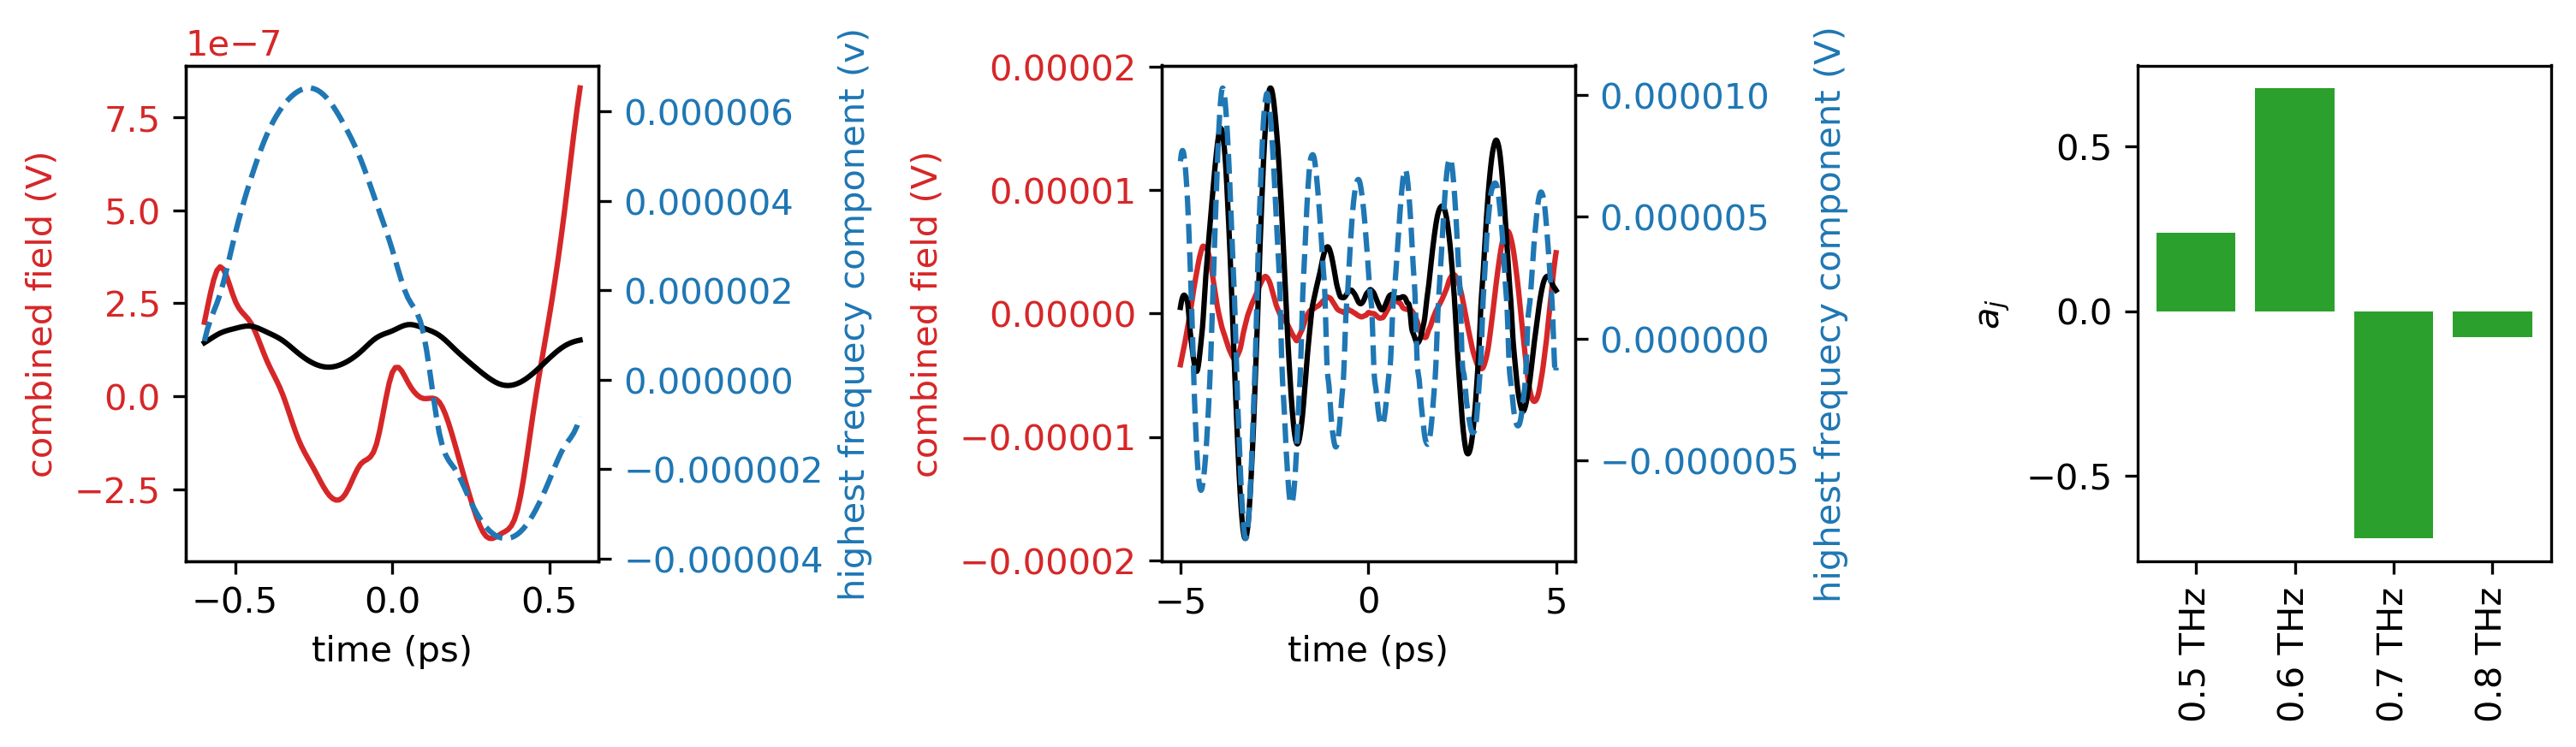

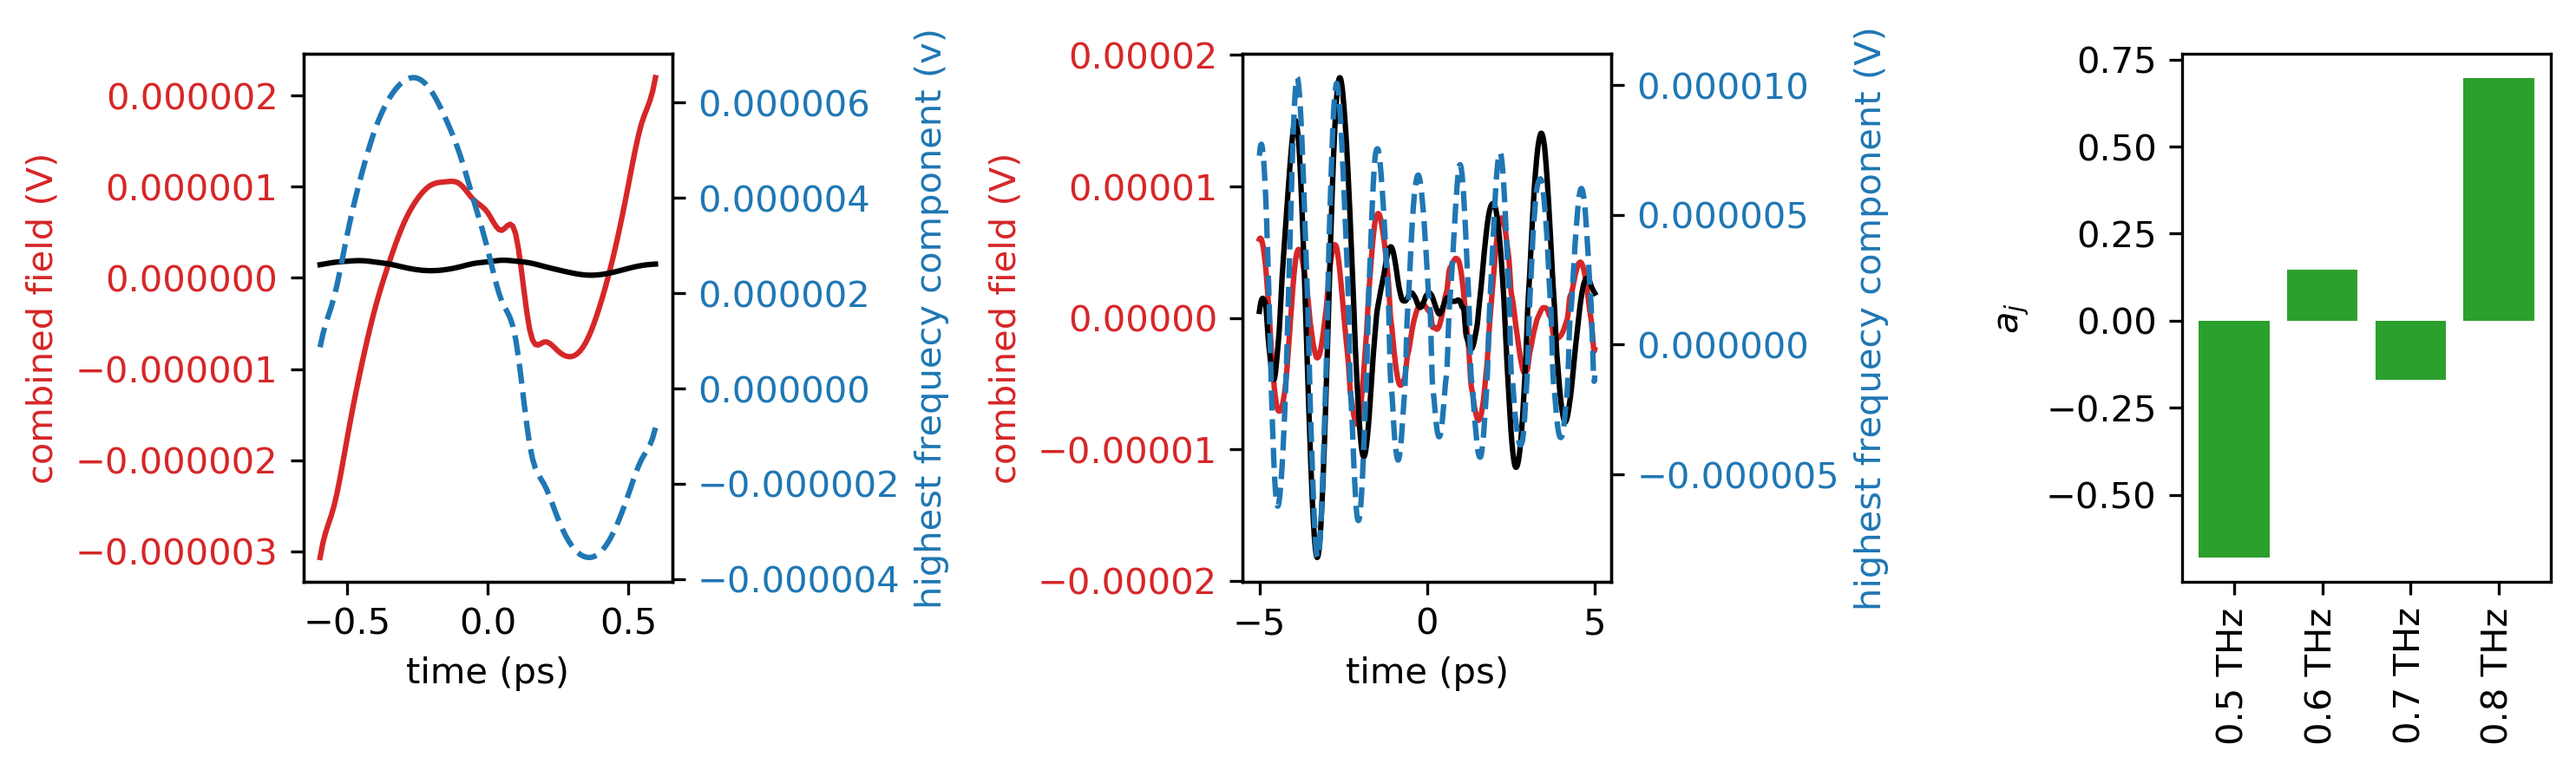

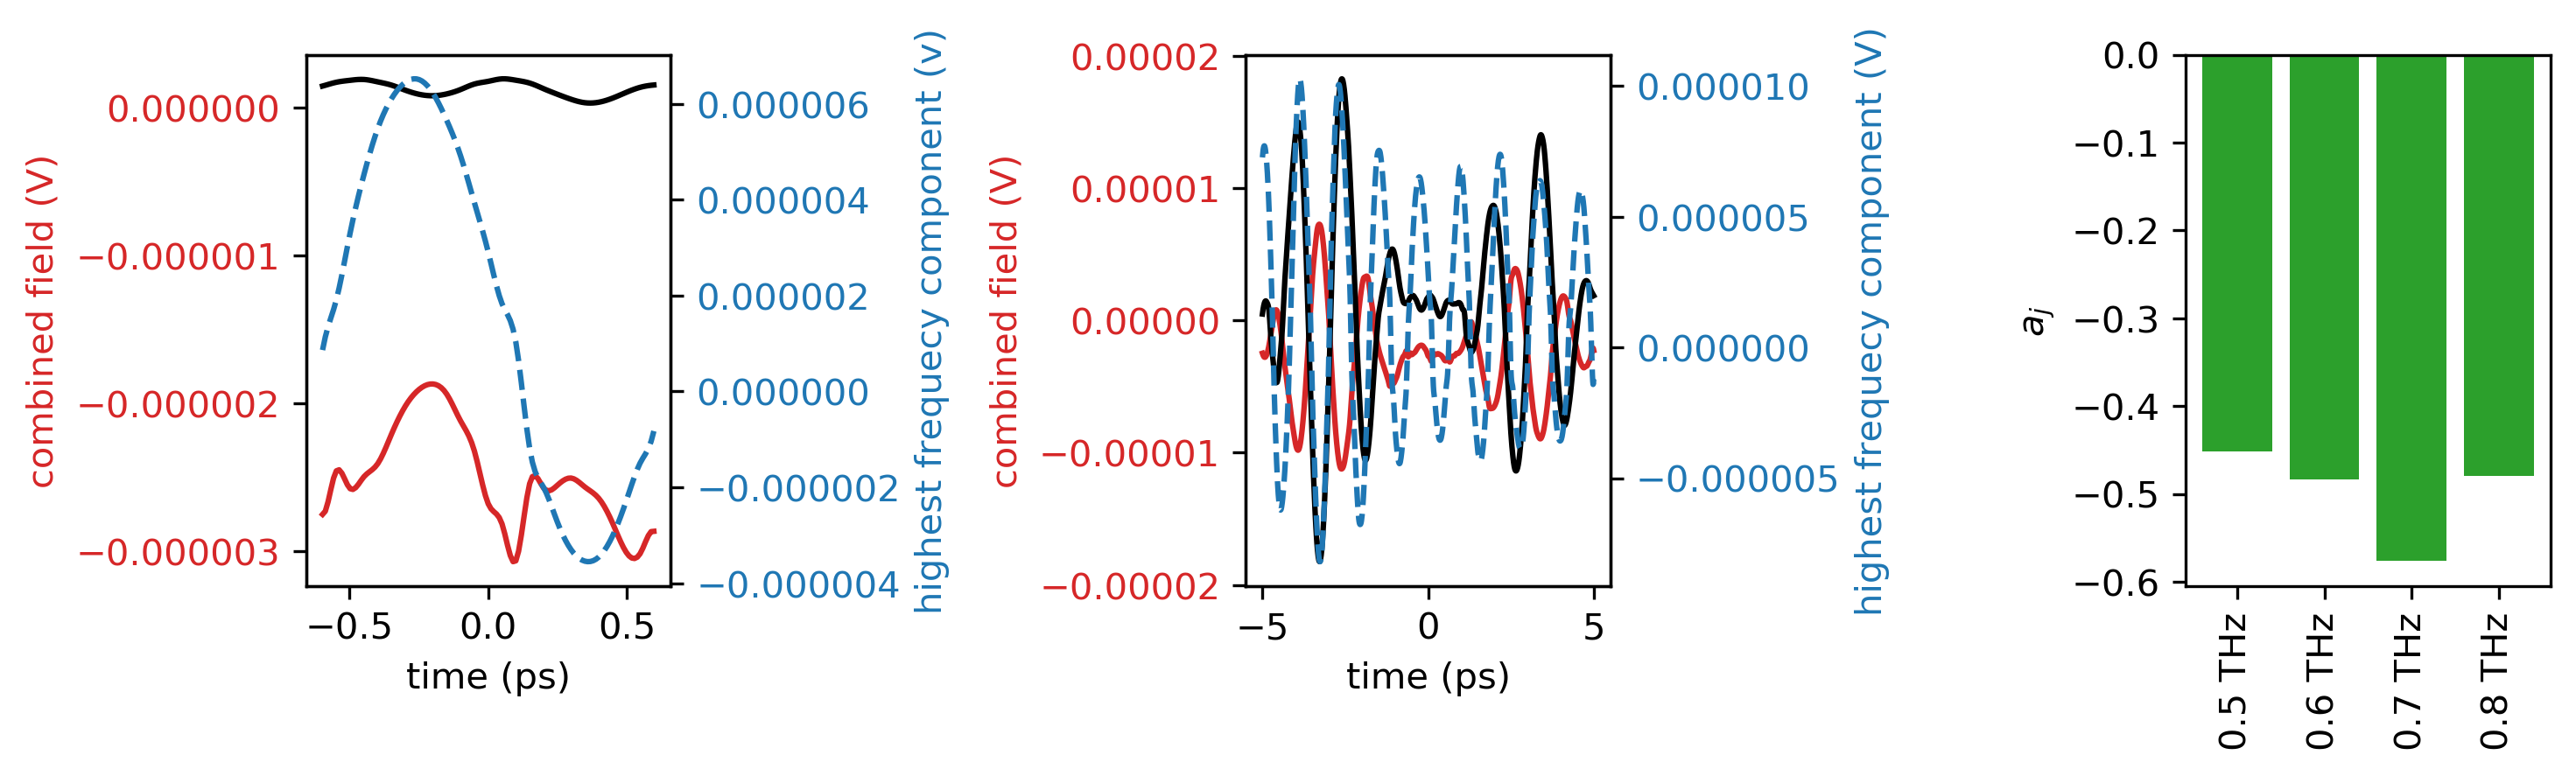

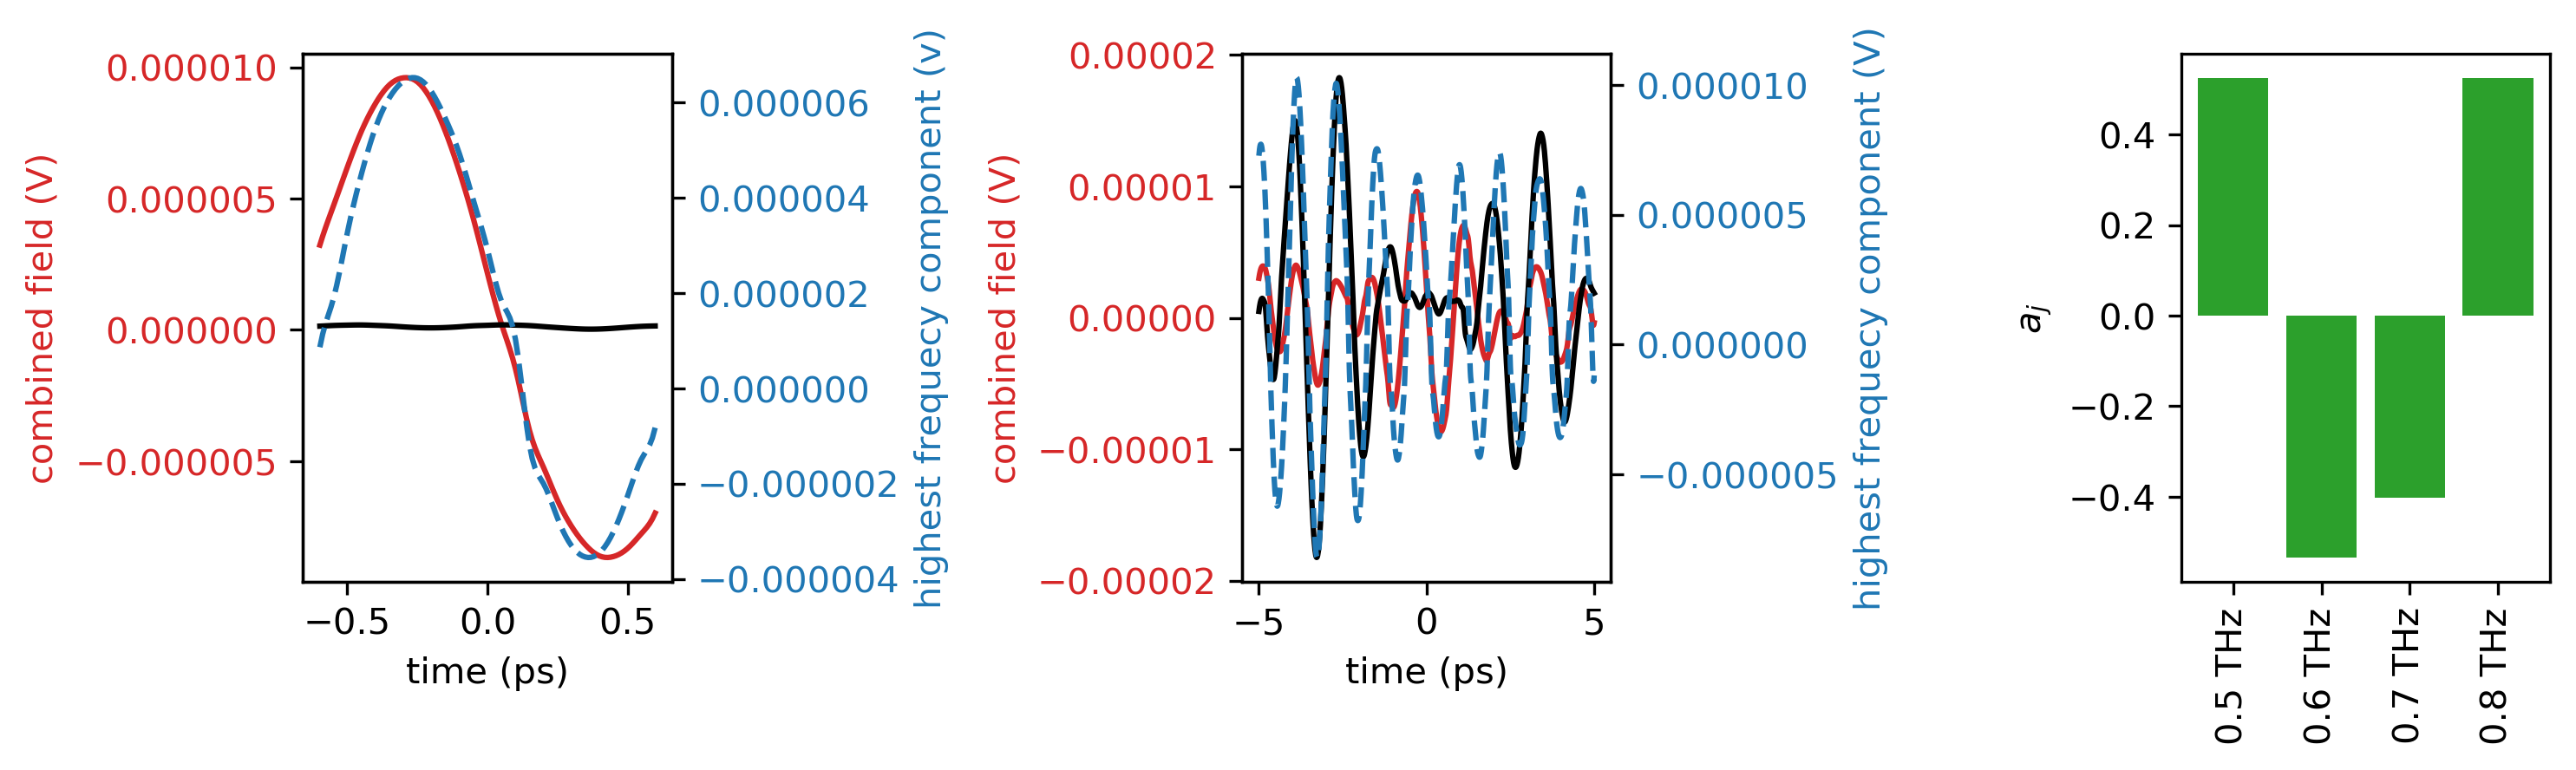

In [15]:
# Use refined time axis for the largest frequency component
fastest = pulses[largest_freq]
t = fastest.time
t = np.linspace(t.min(), t.max(), 5 * t.size)

# extract indices of the observational window
ow1 = np.searchsorted(t, observational_window[0], side='left')
ow2 = np.searchsorted(t, observational_window[1], side='right')

# extract indices of the larger window
Lw1 = np.searchsorted(t, 10 * observational_window[0], side='left')
Lw2 = np.searchsorted(t, 10 * observational_window[1], side='right')

for num, eig_vector in enumerate(vecs.T):
    
    # a sanity check
    #assert np.allclose(eig_vector.T @ S_infty @ eig_vector, 1.)
    
    # Normalizing amplitudes
    #eig_vector = eig_vector / np.abs(eig_vector).max()
    
    # get superoscilating field
    field = sum(
        c * _.interp_field(t) for c, _ in zip(eig_vector, pulses.values())
    )
    
    # plot zoom in view
    fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(10, 3), dpi=300)
    
    t_ow = t[ow1:ow2]
    
    color1 = 'tab:red'
    ax1.set_ylabel('combined field (V)', color=color1)
    ax1.plot(t_ow, field[ow1:ow2], color=color1)
    ax1.plot(t_ow, combined_pulse.interp_field(t_ow) / 10, color='black')
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel('time (ps)')
    
    ax2 = ax1.twinx() 
    
    color2 = 'tab:blue'
    ax2.set_ylabel('highest frequecy component (v)', color=color2)
    ax2.plot(t_ow, fastest.interp_field(t_ow), '--', color=color2)
    #ax2.plot(fastest.time, fastest.field, '*')
    #ax2.set_xlim(observational_window)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    
    # plot zoom out view
    
    ax1 = ax1_
    
    t_lw = t[Lw1:Lw2]
    
    ax1.set_ylabel('combined field (V)', color=color1)
    ax1.plot(t_lw, field[Lw1:Lw2], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.plot(t_lw, combined_pulse.interp_field(t_lw), color='black')
    
    ax1.set_xlabel('time (ps)')
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('highest frequecy component (V)', color=color2)
    ax2.plot(t_lw, fastest.interp_field(t_lw), '--', color=color2)
    #ax2.plot(fastest.time, fastest.field, '*')
    #ax2.set_xlim(10 * np.array(observational_window))
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(eig_vector.size), eig_vector, color='tab:green')
    ax1.set_xticks(np.arange(eig_vector.size))
    ax1.set_xticklabels(pulses, rotation='vertical')
    #ax1.set_xlabel('THz')
    ax1.set_ylabel('$a_j$')
    
    fig.tight_layout()
    
    plt.savefig('fig_{}.png'.format(num), transparent=True)
    
    plt.show()

# New combinatorial method

Define all time possible time delays  

In [16]:
all_time_delays = list(product(*[_.peaks_time for _ in pulses.values()]))
len(all_time_delays)

9000000

Time window for constructing superoscilations

In [17]:
half_period = pulses[largest_freq].half_period
time_window = np.linspace(-half_period, half_period, 100)

## Get superoscilationsby using time delays only 

In [18]:
def get_combined_field(time_delays, time_window):
    return sum(
        _.interp_field(time_window - delay) for delay, _ in zip(time_delays, pulses.values())
    )

def inegral_without_ampl_modulation(time_delays):
    
    return simps(get_combined_field(time_delays, time_window) ** 2, time_window)

In [19]:
with Pool() as pool:
    intensity_without_ampl_modulation = pool.map(inegral_without_ampl_modulation, tqdm(all_time_delays))

Extract the best candidates for getting superoscilations  

In [20]:
intensity_without_ampl_modulation = np.array(intensity_without_ampl_modulation)
indx = np.argsort(intensity_without_ampl_modulation)
intensity_without_ampl_modulation = intensity_without_ampl_modulation[indx]

all_time_delays = np.array(all_time_delays)[indx]

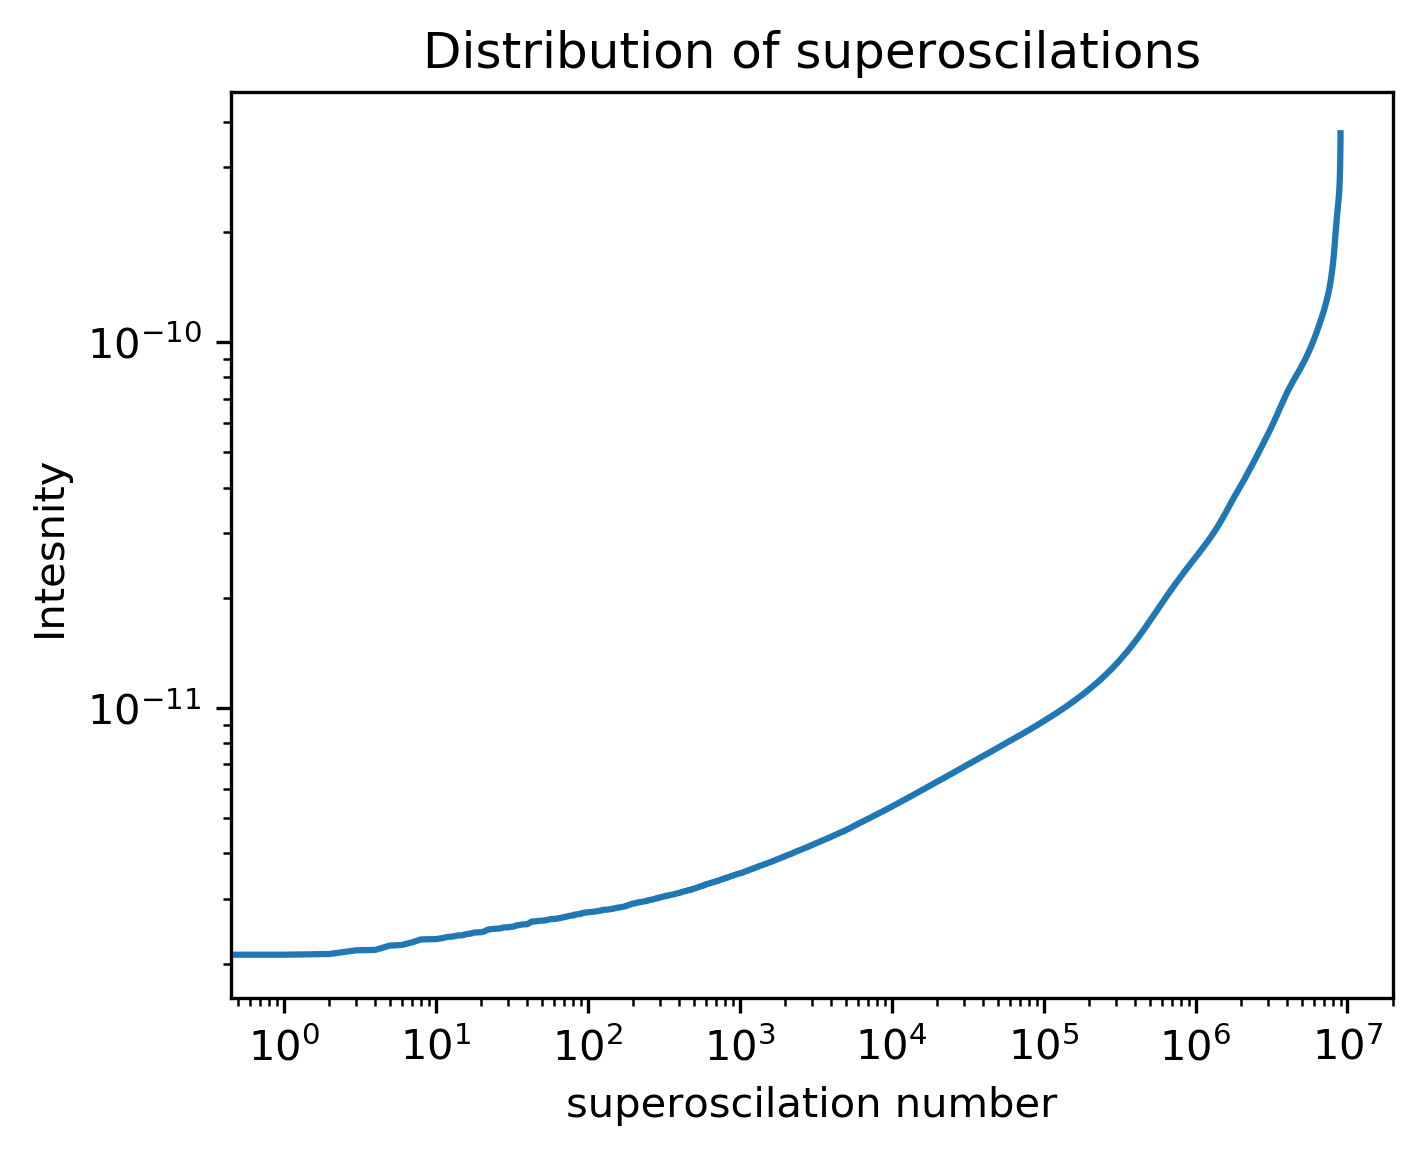

In [21]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(intensity_without_ampl_modulation)
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

## Get superoscilations that best matches the experimental result

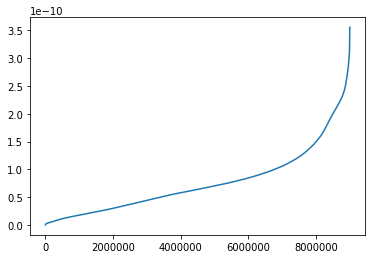

In [22]:
def get_distance_to_experimental(time_delays):
    
    return simps(
        (get_combined_field(time_delays, time_window) - combined_pulse.interp_field(time_window))** 2, 
        time_window
    )

with Pool() as pool:
    distance_to_experimental = pool.map(get_distance_to_experimental, tqdm(all_time_delays))
    
indx = np.argsort(distance_to_experimental)
distance_to_experimental = np.array(distance_to_experimental)[indx]

best_match_time_delays = all_time_delays[indx[0]]

plt.plot(distance_to_experimental)
plt.show()

In [23]:
all_time_delays[indx[:10]]

array([[ 1.35, -0.95,  3.1 ,  1.55],
       [ 1.35, -1.  ,  3.  ,  1.5 ],
       [ 1.4 ,  0.6 , -3.95,  1.5 ],
       [ 1.35, -2.65, -2.45,  2.7 ],
       [-2.45,  1.9 ,  3.7 , -0.9 ],
       [-2.45, -0.95,  3.1 ,  1.55],
       [ 1.35, -1.  ,  3.05,  1.5 ],
       [ 1.35,  3.55,  1.7 ,  3.9 ],
       [ 1.4 , -0.95,  3.05,  1.55],
       [-2.45,  1.9 , -3.3 , -0.85]])

## plot best superoscilations

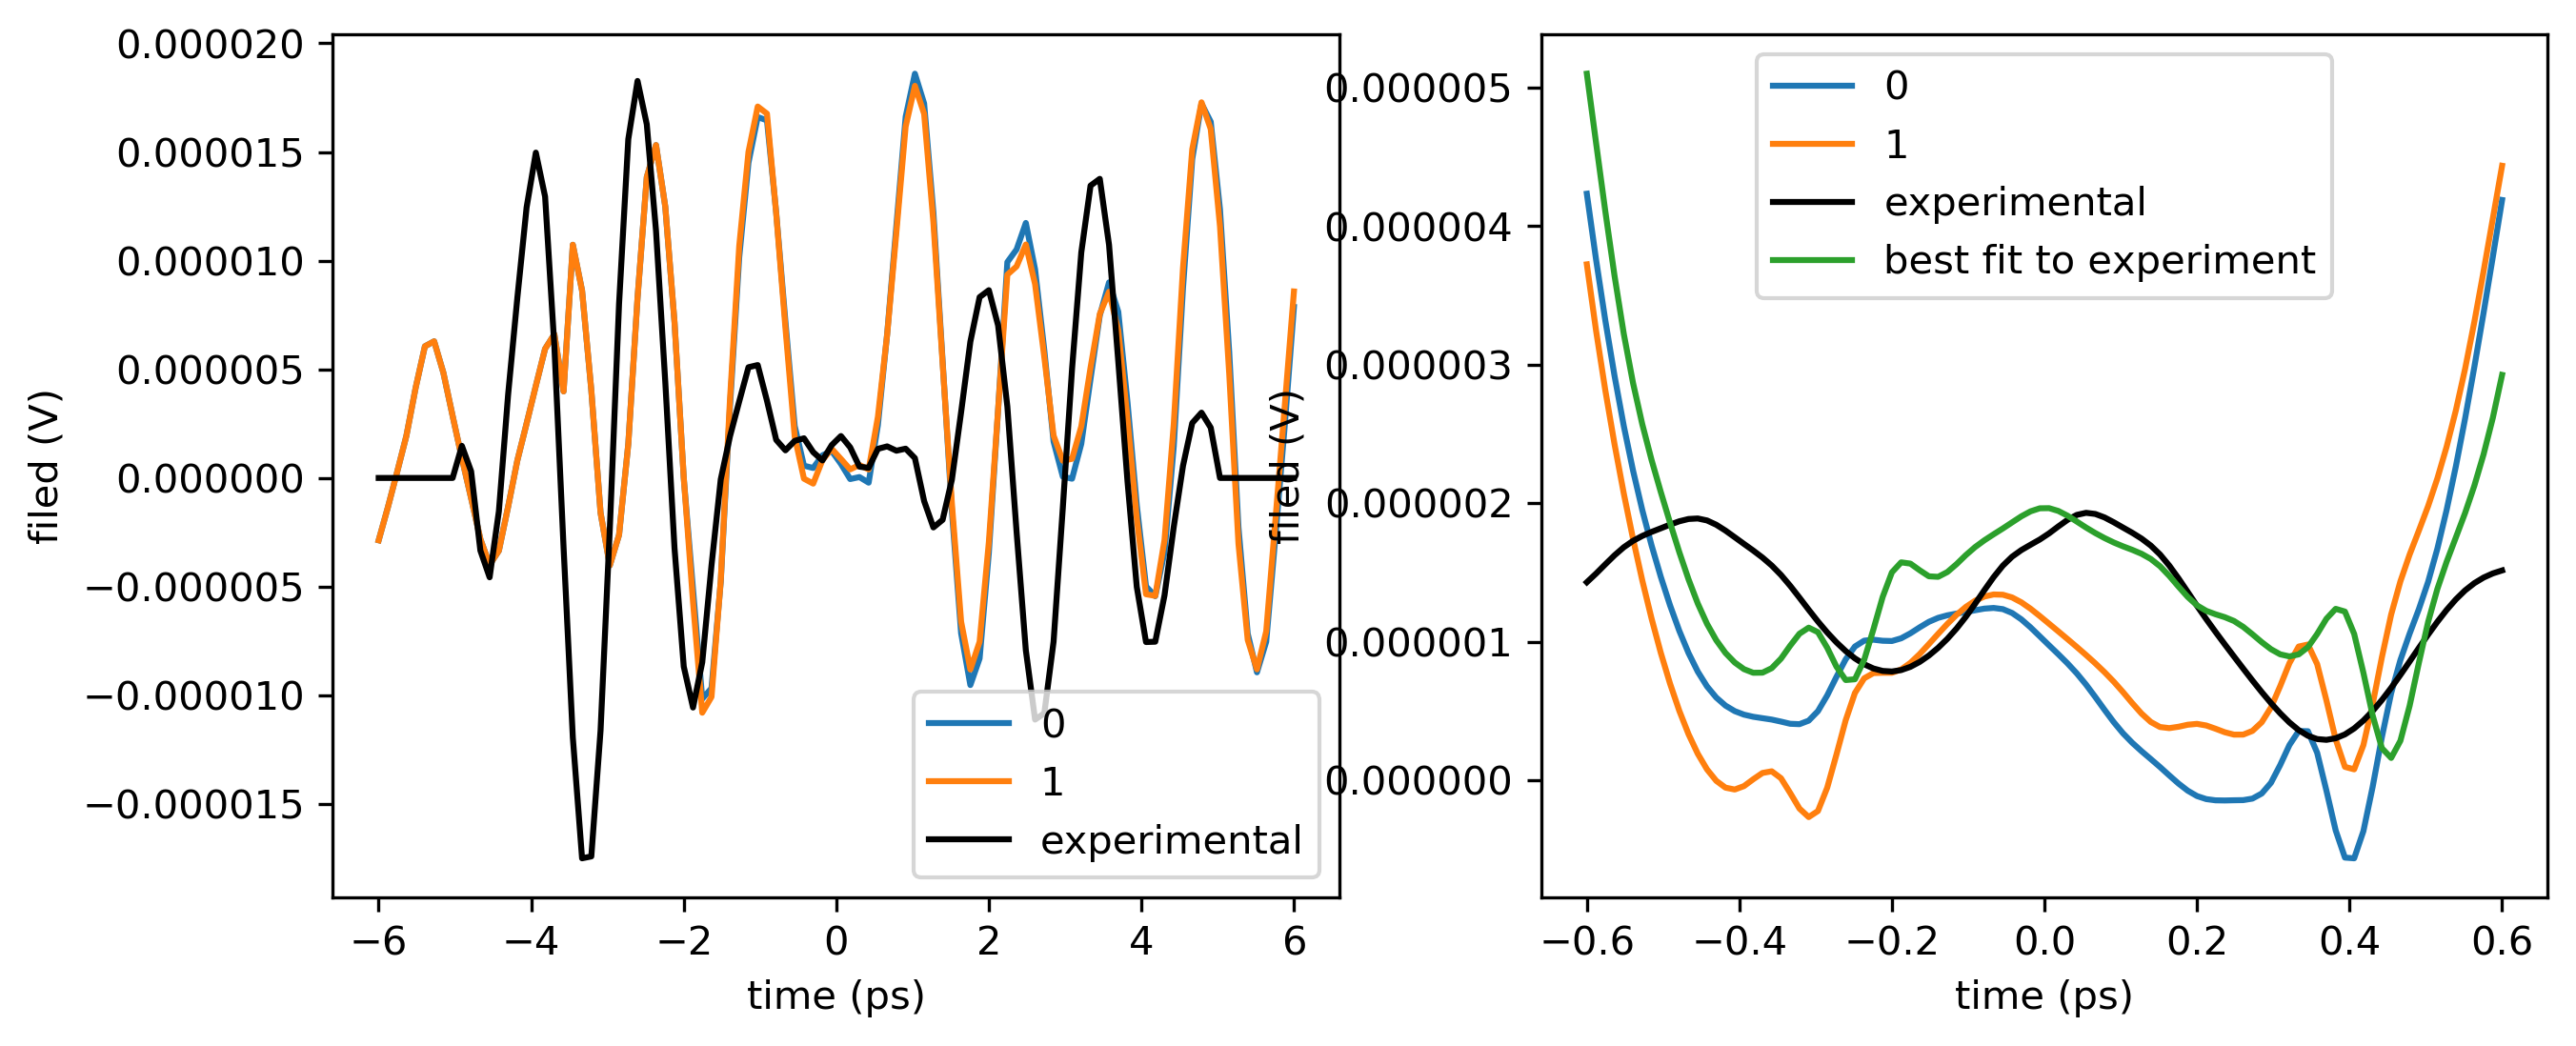

In [28]:
plt.figure(figsize=(10,4), dpi=300)
plt.title("Best superoscilations")

plt.subplot(121)

long_time_window = 10 * time_window

for n, time_delays in enumerate(all_time_delays[:2]):
    plt.plot(long_time_window, get_combined_field(time_delays, long_time_window), label=str(n))

plt.plot(long_time_window, combined_pulse.interp_field(long_time_window), color='black', label='experimental')
    
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()

plt.subplot(122)

for n, time_delays in enumerate(all_time_delays[:2]):
    plt.plot(time_window, get_combined_field(time_delays, time_window), label=str(n))
    
plt.plot(time_window, combined_pulse.interp_field(time_window), color='black', label='experimental')
plt.plot(time_window, get_combined_field(best_match_time_delays, time_window), label="best fit to experiment")

plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()

plt.savefig("results.png")

plt.show()  

In [25]:
all_time_delays[:10]

array([[ 1.35, -2.65,  3.1 ,  1.5 ],
       [ 1.35, -2.65,  3.05,  1.5 ],
       [ 1.4 , -2.65,  3.  ,  1.5 ],
       [-2.45, -2.65,  3.05,  1.5 ],
       [ 3.3 , -2.65,  3.  ,  1.5 ],
       [ 1.4 , -2.65,  3.05,  1.5 ],
       [-2.4 , -2.65,  3.  ,  1.5 ],
       [ 3.35,  1.9 ,  3.2 ,  2.7 ],
       [ 3.3 , -2.75,  3.15,  2.7 ],
       [ 1.45, -2.7 ,  3.  ,  1.5 ]])

## Get superoscilationsby using time delays and amplitude modulations 

In [26]:


def inegral_ampl_modulation(time_delays):
    
    # Amplitude variables
    x = cp.Variable(len(pulses))
    constraints = [0 <= x, x <= 1, sum(x) == 1]

    A = [_.interp_field(time_window - delay) for delay, _ in zip(time_delays, pulses.values())]
    A = np.array(A).T
    
    objective = cp.Minimize(cp.sum_squares(A @ x))
    
    
    prob = cp.Problem(objective, constraints)
    intensity = prob.solve()
    
    return intensity, x.value

In [27]:
all_time_delays_ampl_modulation = all_time_delays.copy()

with Pool() as pool:
    intensity_ampl_modulation, ampl_values = zip(
        *pool.map(inegral_ampl_modulation, tqdm(all_time_delays_ampl_modulation))
    )

Process ForkPoolWorker-326:
Process ForkPoolWorker-325:
Process ForkPoolWorker-332:
Process ForkPoolWorker-324:
Process ForkPoolWorker-327:
Process ForkPoolWorker-298:
Process ForkPoolWorker-277:
Process ForkPoolWorker-292:
Process ForkPoolWorker-331:
Process ForkPoolWorker-272:
Process ForkPoolWorker-329:
Process ForkPoolWorker-273:
Process ForkPoolWorker-330:
Process ForkPoolWorker-268:
Process ForkPoolWorker-319:
Process ForkPoolWorker-258:
Process ForkPoolWorker-320:
Process ForkPoolWorker-265:
Process ForkPoolWorker-274:
Process ForkPoolWorker-269:
Process ForkPoolWorker-278:
Process ForkPoolWorker-263:
Process ForkPoolWorker-333:
Process ForkPoolWorker-293:
Process ForkPoolWorker-322:
Process ForkPoolWorker-266:
Process ForkPoolWorker-295:
Process ForkPoolWorker-290:
Process ForkPoolWorker-260:
Process ForkPoolWorker-280:
Process ForkPoolWorker-270:
Process ForkPoolWorker-243:
Process ForkPoolWorker-250:
Process ForkPoolWorker-335:
Process ForkPoolWorker-245:
Process ForkPoolWork

Solver interrupted


Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-323:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-238:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-284:
Process ForkPoolWorker-318:
Process ForkPoolWorker-242:
Process ForkPoolWorker-334:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-299:
Process ForkPoolWorker-289:
Traceback (most recent call last):
Process ForkPoolWorker-276:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-296:
Process ForkPoolWorker-304:
Traceback (most recent call last):
Process ForkPoolWorker-300:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/hom

Traceback (most recent call last):
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
AttributeError: 'AddExpression' object has no attribute '_lazy_canonical_form'
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
AttributeError: 'AddExpression' object has no attribute '_lazy_canonical_form'
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/denys/anaconda3/lib/pyth

  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/denys/anaconda3/lib/pytho

  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 9

  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
AttributeError: 'AddExpression' object has no attribute '_lazy_canonical_form'
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/denys/anaconda3/lib/python3.7/mult

  File "<ipython-input-26-bc290dca2881>", line 1, in inegral_ampl_modulation
    def inegral_ampl_modulation(time_delays):
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args

  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 473, in solve
    return solve_func(self, *args, **kwargs)
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 473, in solve
    return solve_func(self, *args, **kwargs)
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "<ipython-input-

  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 473, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<ipython-input-26-bc290dca2881>", line 1, in inegral_ampl_modulation
    def inegral_ampl_modulation(time_delays):
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 473, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 473, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 473, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/denys/anaconda3/lib/python3.7/mul

  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 976, in _solve
    self, data, warm_start, verbose, kwargs)
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
AttributeError: 'MulExpression' object has no attribute '_lazy_canonical_form'
  File "<ipython-inpu

  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 473, in solve
    return solve_func(self, *args, **kwargs)
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "/home/denys/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))

During handling of the above exception, another exception occurred:

  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 473, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/constraints/nonpos.py", line 154, in __init__
    self._expr = lhs - rhs
  File "<ipython-input-26-bc290dca2881>", line 14, in inegral_ampl_modulation
    intensity = prob.solve()
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 967, in _solve
    solver, gp, enforce_dpp, verbose)
  Fi

  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 473, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 473, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 967, in _solve
    solver, gp, enforce_dpp, verbose)
AttributeError: 'index' object has no attribute '_lazy_canonical_form'
KeyboardInterrupt
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 979, in _solve
    self.unpack_results(solution, solving_chain, inverse_data)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 627, in get_problem_data
    data, inverse_data = solving_chain.apply(self, verbose)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py", line 48, in cast_op
    other 

  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/chain.py", line 76, in apply
    problem, inv = r.apply(problem)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 473, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 967, in _solve
    solver, gp, enforce_dpp, verbose)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 627, in get_problem_data
    data, inverse_data = solving_chain.apply(self, verbose)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 627, in get_problem_data
    data, inverse_data = solving_chain.apply(self, verbose)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/chain.py", line 76, in apply
    problem, inv = r.apply(problem)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/p

  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/chain.py", line 76, in apply
    problem, inv = r.apply(problem)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py", line 478, in cast_to_const
    return expr if isinstance(expr, Expression) else cvxtypes.constant()(expr)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 967, in _solve
    solver, gp, enforce_dpp, verbose)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/chain.py", line 76, in apply
    problem, inv = r.apply(problem)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 967, in _solve
    solver, gp, enforce_dpp, verbose)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 967, in _solve
    solver, gp, enforce_dpp, verbose)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/chain.py", line

  File "/home/denys/anaconda3/lib/python3.7/site-packages/osqp/interface.py", line 37, in setup
    self._model.setup(*unpacked_data, **settings)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py", line 57, in __init__
    other = self.__class__(coo_matrix(arg1, shape=shape))
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/cvxcore/python/canonInterface.py", line 358, in get_problem_matrix
    param_size_plus_one))
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/solvers/qp_solvers/osqp_qpif.py", line 105, in solve_via_data
    solver_cache[self.name()] = (solver, data, results)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/utilities/coeff_extractor.py", line 111, in extract_quadratic_coeffs
    affine_expr.size)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/solvers/qp_solvers/qp_solver.py", line 76, in apply
    P, q, d, AF, bg = problem.apply_parameters()
  File 

  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 627, in get_problem_data
    data, inverse_data = solving_chain.apply(self, verbose)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/qp2quad_form/qp_matrix_stuffing.py", line 291, in apply
    inverse_data.param_id_map)
  File "/home/denys/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py", line 582, in get_problem_data
    solver=solver, gp=gp, enforce_dpp=enforce_dpp)


KeyboardInterrupt: 

Extract the best candidates for getting superoscilations  

In [ ]:
intensity_ampl_modulation = np.array(intensity_ampl_modulation)

# unlike the time delay permutation objective function, we need to multiply by dt to directly compare two
intensity_ampl_modulation *= time_window[1] - time_window[0]

ampl_values = np.array(ampl_values)
ampl_values = ampl_values[indx]

indx = np.argsort(intensity_ampl_modulation)
intensity_ampl_modulation = intensity_ampl_modulation[indx]

all_time_delays_ampl_modulation = all_time_delays_ampl_modulation[indx]

In [ ]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(intensity_ampl_modulation, label="phase and amplitude modulation")
plt.loglog(intensity_without_ampl_modulation, label="phase modulation only")
plt.legend()
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

## Is there evidence that amplitude modulation is used (hence, helpful)?

In [ ]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Standard deviation of the amplitude modulations")
plt.loglog(np.std(ampl_values, axis=1))
plt.xlabel('superoscilation number')
plt.ylabel('Standard deviation of the amplitude modulations')
plt.show()

## plot best superoscilations

In [ ]:
def get_combined_field_ampl_modulation(time_delays, amplitudes, time_window):
    return sum(
        a * _.interp_field(time_window - delay) for delay, a, _ in zip(time_delays, amplitudes, pulses.values())
    )

plt.figure(figsize=(10,4), dpi=300)
plt.title("Best superoscilations with amplitude modulation")

plt.subplot(121)

long_time_window = 10 * time_window

for n, (time_delays, amplitudes) in enumerate(zip(all_time_delays_ampl_modulation[:5], ampl_values[:5])):
    plt.plot(
        long_time_window, 
        get_combined_field_ampl_modulation(time_delays, amplitudes, long_time_window), 
        label=str(n)
    )

plt.plot(long_time_window, combined_pulse.interp_field(long_time_window), color='black', label='experimental')

plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()

plt.subplot(122)

for n, (time_delays, amplitudes) in enumerate(zip(all_time_delays_ampl_modulation[:5], ampl_values[:5])):
    plt.plot(
        time_window, 
        get_combined_field_ampl_modulation(time_delays, amplitudes, time_window), 
        label=str(n)
    )
    
plt.plot(time_window, combined_pulse.interp_field(time_window), color='black', label='experimental')

plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.legend()


plt.show()  

In [ ]:
all_time_delays_ampl_modulation[:10]

In [ ]:
ampl_values[:20]